# Step 2: Exploratory Data Analysis


**Owner**: Sonal Kiran Hansra<br>**Last Update**: August 18, 2023

<a id="0"></a> <br>
### Table of Contents  
1. [Introduction](#1)


2. [Exploratory Data Analysis](#2)
    
    a. [Capital Bikeshare Data](#3)

    b. [Weather Data](#4)

    c. [Holiday Data](#5)
    
    
3. [Combining All Datasets](#6)


4. [Feature Engineering](#7)


5. [Building Baseline Model](#8)

    a. [Trend-Season Decomposition](#9)
    
    b. [Naive Baseline Model](#10)
    
    c. [Trend-Season Based Baseline Model](#11)

In [1]:
# from platform import python_version
# print(python_version())
import warnings
warnings.filterwarnings("ignore")

<a id="1"></a> 
## Introduction

**In step 1 of this project we looked at data from 3 different sources (Capital Bikeshare, NOAA - weather, DCHR - holiday) and processed them for further use. In this notebook we will pick up where we left and conduct an in-depth EDA on that processed data. We will also address all the action items from step 1 and prepare our data for modeling.**

<a id="2"></a> 
## Exploratory Data Analysis

In [2]:
# importing libraries

import pandas as pd
pd.set_option('display.max_columns', 1000)
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from statsmodels.api import tsa
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

<a id="3"></a>
### **1. Bikeshare Data**

In [3]:
# loading bikeshare data

bikeshare_data = pd.read_csv(
    '/Users/sonalkiranhansra/Desktop/BrainStation_Sonal/Classes/Capstone/data/cleaned_data/bike_data_rolled_up.csv',
    index_col=0)

# looking at data head

display(bikeshare_data.head())
display(bikeshare_data.info())

date  member  casual
0  2012-01-01    1572     688
1  2012-01-02    1693     244
2  2012-01-03    2130      89
3  2012-01-04    2262      95
4  2012-01-05    3111     140

<class 'pandas.core.frame.DataFrame'>
Index: 4195 entries, 0 to 4194
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    4195 non-null   object
 1   member  4195 non-null   int64 
 2   casual  4195 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 131.1+ KB


None

**<span style='color: DarkRed'>To begin with, we know from data preparation in step 1 that we are missing data for a few dates. Let's look at that again -</span>**

In [4]:
# checking for missing dates in date column

full_date_range = pd.date_range(end=max(bikeshare_data.date), start=min(bikeshare_data.date))

print(f'Our dataset is missing data for {full_date_range.shape[0]-bikeshare_data.shape[0]} days!\
\nThe missing dates are -\n',full_date_range.difference(bikeshare_data.date))

Our dataset is missing data for 4 days!
The missing dates are -
 DatetimeIndex(['2016-01-23', '2016-01-24', '2016-01-25', '2016-01-26'], dtype='datetime64[ns]', freq=None)


**<span style='color: DarkRed'>Let's look at this visually -</span>**

In [5]:
# setting `date` column as datetime object

bikeshare_data.date = pd.to_datetime(bikeshare_data.date).dt.date
display(bikeshare_data.head())

# resetting index to data

bikeshare_data.set_index('date', inplace=True)
display(bikeshare_data.head())

date  member  casual
0  2012-01-01    1572     688
1  2012-01-02    1693     244
2  2012-01-03    2130      89
3  2012-01-04    2262      95
4  2012-01-05    3111     140

member  casual
date                      
2012-01-01    1572     688
2012-01-02    1693     244
2012-01-03    2130      89
2012-01-04    2262      95
2012-01-05    3111     140

In [6]:
# extending the index to full range

bikeshare_data = bikeshare_data.reindex(full_date_range)

# verifying - we expect to see 4 null values in each column corresponding to the 4 missing dates

bikeshare_data.isna().sum()

member    4
casual    4
dtype: int64

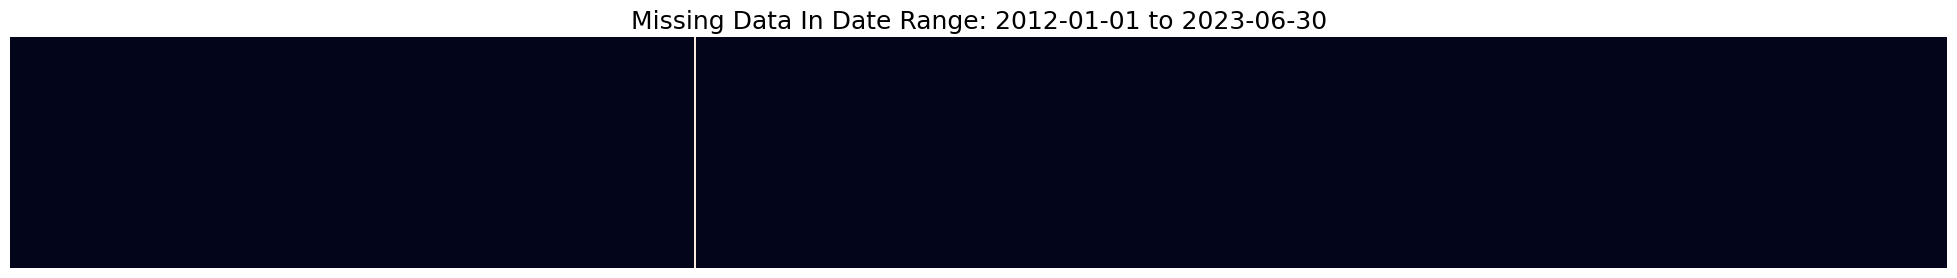

In [7]:
# plotting

plt.figure(figsize=(25, 3))
sns.heatmap(bikeshare_data.T.isna(), cbar=False)
plt.xticks([]) # tick marks off
plt.yticks([]) # tick marks off
plt.title(f'Missing Data In Date Range: {bikeshare_data.index[0].date()} to {bikeshare_data.index[-1].date()}',
         fontdict={'fontsize': 18})
plt.show()

**<span style='color: DarkRed'>We don't see any large blocks of data missing. But we do have missing data for 4 continuous days which makes up less than 0.001%. Let's look more closely at our data to see if there are any patterns which we can use to impute our data. Let's also create a `total_demand` column to capture how many bikes were actually rented on any given day regardless of membership.</span>**

In [8]:
# creating total_demand column

bikeshare_data['total_demand'] = bikeshare_data.member + bikeshare_data.casual

# verifying 

display(bikeshare_data.head())
bikeshare_data.total_demand[0] == bikeshare_data.casual[0]+bikeshare_data.member[0]

member  casual  total_demand
2012-01-01  1572.0   688.0        2260.0
2012-01-02  1693.0   244.0        1937.0
2012-01-03  2130.0    89.0        2219.0
2012-01-04  2262.0    95.0        2357.0
2012-01-05  3111.0   140.0        3251.0

True

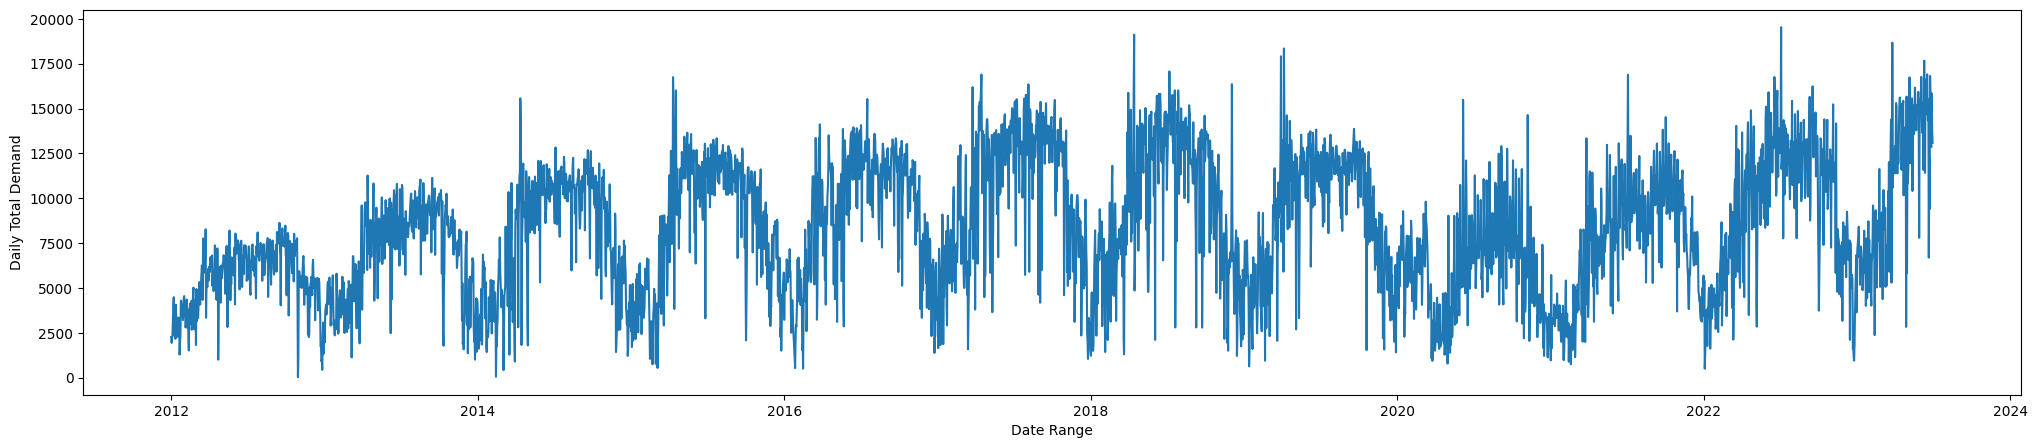

In [9]:
# plotting total demand

plt.figure(figsize=(25,5))
sns.lineplot(data=bikeshare_data, y='total_demand', x=bikeshare_data.index)
plt.xlabel('Date Range')
plt.ylabel('Daily Total Demand')
plt.show()

**<span style='color: DarkRed'>We can observe three things -</span>**

**<span style='color: DarkRed'>1. There is seasonality in our data</span>**

**<span style='color: DarkRed'>2. There seems to be some anomaly around the year 2020, possibly due to the pandemic!</span>**

**<span style='color: DarkRed'>3. There seems to be an increasing trend in the demand during peak season over the years, except around the year 2020.</span>**

**<span style='color: DarkRed'>We will look at the anomaly during the pandemic years in some time, but first, let's zoom in on the data from 2015 and 2016 to finalize data imputation strategy.</span>**

In [10]:
# selecting January 2016 data

select_jan_2016 = bikeshare_data[('01-01-2016'<=bikeshare_data.index) & (bikeshare_data.index<'02-01-2016')]

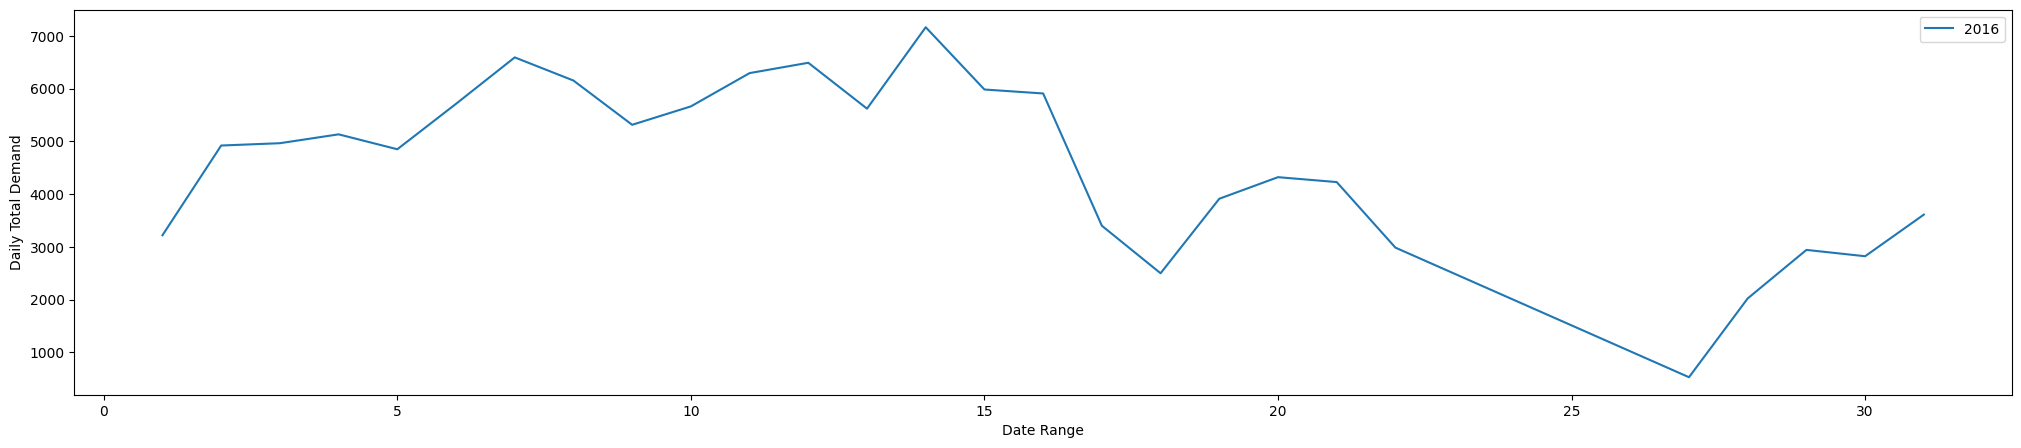

In [11]:
# plotting total demand

plt.figure(figsize=(25,5))
sns.lineplot(data=select_jan_2016, y='total_demand', x=select_jan_2016.index.day, label='2016')
plt.xlabel('Date Range')
plt.ylabel('Daily Total Demand')
plt.legend()
plt.show()

**<span style='color: DarkRed'>Let's also look at the holiday data to check if there were any holidays between Jan 23, 2016 and Jan 26, 2016.</span>**

In [12]:
# loading holiday data

holiday_data = pd.read_csv('/Users/sonalkiranhansra/Desktop/BrainStation_Sonal/Classes/Capstone/data/holidays/holidays_weekends_2012_2023.csv')
print(holiday_data.head())
print(holiday_data.info())

         date  weekend  holiday  weekend_holiday
0  01/01/2012        1        0                1
1  02/01/2012        0        1                1
2  03/01/2012        0        0                0
3  04/01/2012        0        0                0
4  05/01/2012        0        0                0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             4383 non-null   object
 1   weekend          4383 non-null   int64 
 2   holiday          4383 non-null   int64 
 3   weekend_holiday  4383 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 137.1+ KB
None


**<span style='color: DarkRed'>Let's convert the `date` column to datetime format.</span>**

In [13]:
holiday_data.date = pd.to_datetime(holiday_data.date, format="%d/%m/%Y")
print(holiday_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             4383 non-null   datetime64[ns]
 1   weekend          4383 non-null   int64         
 2   holiday          4383 non-null   int64         
 3   weekend_holiday  4383 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 137.1 KB
None


**<span style='color: DarkRed'>Now let's look at the holiday data between Jan 23, 2016 and Jan 26, 2016.</span>**

In [14]:
# looking at holiday data

holiday_data[('2016-01-23'<=holiday_data.date) & (holiday_data.date<'2016-01-27')]

date  weekend  holiday  weekend_holiday
1483 2016-01-23        1        0                1
1484 2016-01-24        1        0                1
1485 2016-01-25        0        0                0
1486 2016-01-26        0        0                0

In [15]:
# checking for holidays in Jan'16

holiday_data[('2016-01-01'<=holiday_data.date) & (holiday_data.date<'2016-02-01') & (holiday_data.holiday==1)]

date  weekend  holiday  weekend_holiday
1461 2016-01-01        0        1                1
1478 2016-01-18        0        1                1

**<span style='color: DarkRed'>Looking at the chart above, there seems to be no visible weekly pattern that we can use to guide our imputaion. There are several other ways for us to impute the missing data, one such way is to use the day-of-week average from the last 3 weeks. Let's go ahead and employ this method. This will help us preserve any weekday-weekend information that may be present and will also even out the impact of any holiday (such as the one on Jan 18) which would impact the imputation if we look back just one week.</span>**

In [16]:
saturdays = pd.date_range(end='01/23/2016', freq='W-SAT', periods=4).date

print('Average demand based on last 3 Saturdays from 01/23/2016\n')
print(bikeshare_data.loc[saturdays[:3],:].mean())

# updating values in dataset

bikeshare_data.loc['2016-01-23',:] = bikeshare_data.loc[saturdays[:3],:].mean()

# verifying
bikeshare_data.loc['2016-01-23']

Average demand based on last 3 Saturdays from 01/23/2016

member          4140.0
casual          1241.0
total_demand    5381.0
dtype: float64


member          4140.0
casual          1241.0
total_demand    5381.0
Name: 2016-01-23 00:00:00, dtype: float64

In [17]:
sundays = pd.date_range(end='01/24/2016', freq='W-SUN', periods=4)

print('Average demand based on last 3 Sundays from 01/24/2016\n')
print(bikeshare_data.loc[sundays[:3],:].mean())

# updating values in dataset

bikeshare_data.loc['2016-01-24',:] = round(bikeshare_data.loc[sundays[:3],:].mean())

# verifying
bikeshare_data.loc['2016-01-24']

Average demand based on last 3 Sundays from 01/24/2016

member          3741.333333
casual           934.666667
total_demand    4676.000000
dtype: float64


member          3741.0
casual           935.0
total_demand    4676.0
Name: 2016-01-24 00:00:00, dtype: float64

In [18]:
mondays = pd.date_range(end='01/25/2016', freq='W-MON', periods=4)

print('Average demand based on last 3 Mondays from 01/25/2016\n')
print(bikeshare_data.loc[mondays[:3],:].mean())

# updating values in dataset

bikeshare_data.loc['2016-01-25',:] = round(bikeshare_data.loc[mondays[:3],:].mean())

# verifying
bikeshare_data.loc['2016-01-25']

Average demand based on last 3 Mondays from 01/25/2016

member          4360.666667
casual           281.333333
total_demand    4642.000000
dtype: float64


member          4361.0
casual           281.0
total_demand    4642.0
Name: 2016-01-25 00:00:00, dtype: float64

In [19]:
tuesdays = pd.date_range(end='01/26/2016', freq='W-TUE', periods=4)
print('Average demand based on last 3 Tuesdays from 01/26/2016\n')
print(bikeshare_data.loc[tuesdays[:3],:].mean())

# updating values in dataset

bikeshare_data.loc['2016-01-26',:] = bikeshare_data.loc[tuesdays[:3],:].mean()

# verifying
bikeshare_data.loc['2016-01-26']

Average demand based on last 3 Tuesdays from 01/26/2016

member          4853.0
casual           231.0
total_demand    5084.0
dtype: float64


member          4853.0
casual           231.0
total_demand    5084.0
Name: 2016-01-26 00:00:00, dtype: float64

In [20]:
# verifying 

display(bikeshare_data[('2016-01-01'<=bikeshare_data.index) & (bikeshare_data.index<'2016-02-01')])

bikeshare_data.isna().sum()

member  casual  total_demand
2016-01-01  2221.0   999.0        3220.0
2016-01-02  3399.0  1522.0        4921.0
2016-01-03  3723.0  1242.0        4965.0
2016-01-04  4859.0   274.0        5133.0
2016-01-05  4601.0   249.0        4850.0
2016-01-06  5459.0   253.0        5712.0
2016-01-07  6221.0   371.0        6592.0
2016-01-08  5806.0   347.0        6153.0
2016-01-09  4549.0   765.0        5314.0
2016-01-10  4707.0   956.0        5663.0
2016-01-11  5866.0   428.0        6294.0
2016-01-12  6103.0   387.0        6490.0
2016-01-13  5349.0   271.0        5620.0
2016-01-14  6686.0   478.0        7164.0
2016-01-15  5477.0   506.0        5983.0
2016-01-16  4472.0  1436.0        5908.0
2016-01-17  2794.0   606.0        3400.0
2016-01-18  2357.0   142.0        2499.0
2016-01-19  3855.0    57.0        3912.0
2016-01-20  4257.0    64.0        4321.0
2016-01-21  4157.0    71.0        4228.0
2016-01-22  2923.0    62.0        2985.0
2016-01-23  4140.0  1241.0        5381.0
2016-01-24  3741.0   935.0        4676.0
2016-01-25  4361.0   281.0        4642.0
2016-01-26  4853.0   231.0        5084.0
2016-01-27   525.0     3.0         528.0
2016-01-28  1984.0    38.0        2022.0
2016-01-29  2848.0    94.0        2942.0
2016-01-30  2501.0   321.0        2822.0
2016-01-31  3134.0   477.0        3611.0

member          0
casual          0
total_demand    0
dtype: int64

**<span style='color: DarkRed'>Now that we have imputed our data, let's plot the total demand for the month of Jan, 2016 and check again. We will also create a dynamic plot of the demand from 2012 till 2023 to understand the impact of Covid on bike demands.</span>**

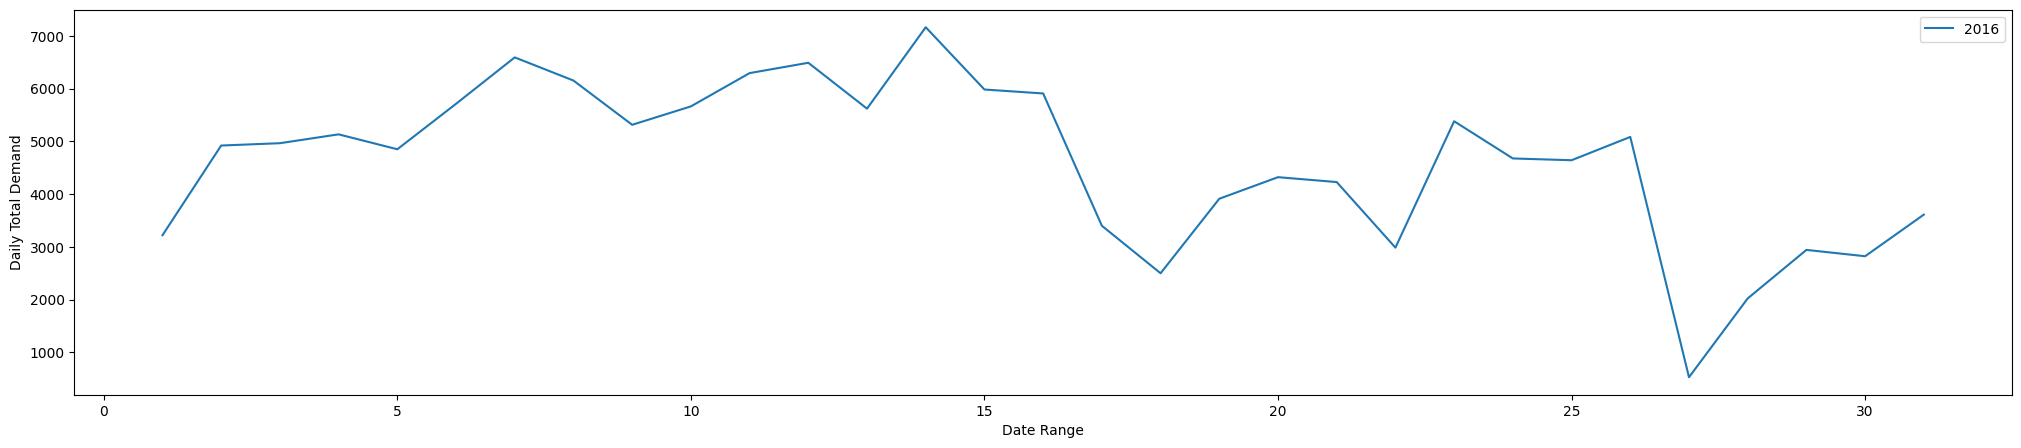

In [21]:
# selecting January 2016 data

select_jan_2016 = bikeshare_data[('01-01-2016'<=bikeshare_data.index) & (bikeshare_data.index<'02-01-2016')]

# plotting total demand

plt.figure(figsize=(25,5))
sns.lineplot(data=select_jan_2016, y='total_demand', x=select_jan_2016.index.day, label='2016')
plt.xlabel('Date Range')
plt.ylabel('Daily Total Demand')
plt.legend()
plt.show()

In [22]:
# plotting with plotly for a dynamic view of bike demand over time

fig = px.line(bikeshare_data, x=bikeshare_data.index, y=bikeshare_data.total_demand)

# axis labels and title
fig.update_layout(
    yaxis_title="Daily Total Demand", 
    legend_title="", 
    title="Daily Total Demand From Jan 2012 to Jun 2023"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [23]:
bikeshare_data_yearly = bikeshare_data.resample("A").mean()
display(bikeshare_data_yearly)

member       casual  total_demand
2012-12-31  4525.278689  1018.147541   5543.426230
2013-12-31  5574.821918  1426.608219   7001.430137
2014-12-31  6281.246575  1699.964384   7981.210959
2015-12-31  6874.906849  1853.602740   8728.509589
2016-12-31  7155.109290  2008.215847   9163.325137
2017-12-31  7605.421918  2689.857534  10295.279452
2018-12-31  7650.873973  2055.109589   9705.983562
2019-12-31  8102.071233  1208.660274   9310.731507
2020-12-31  3791.571038  2265.571038   6057.142077
2021-12-31  4474.868493  3059.052055   7533.920548
2022-12-31  5603.027397  3922.402740   9525.430137
2023-12-31  6716.651934  4078.723757  10795.375691

**<span style='color: DarkRed'>Zooming in to the year 2020 and 2021, we can clearly see that the demand for bike rentals plummeted by 35% due to the lockdowns during Covid!</span>**

In [24]:
# let's look at the monthly trend over time

bikeshare_data_monthly = bikeshare_data.resample("M").sum()

bikeshare_data_monthly.head()

member   casual  total_demand
2012-01-31   86901.0   8970.0       95871.0
2012-02-29   93526.0   8708.0      102234.0
2012-03-31  131605.0  31605.0      163210.0
2012-04-30  134021.0  38454.0      172475.0
2012-05-31  149494.0  44224.0      193718.0

In [25]:
fig = px.line(bikeshare_data_monthly, x=bikeshare_data_monthly.index, y="total_demand",)
fig.update_layout(
    yaxis_title="Total Demand", 
    xaxis_title="Year",
    legend_title="", 
    title="Monthly Bike Demand From 2012 to 2023"
)
fig.show()

**<span style='color: DarkRed'>The peak months for bike rental were, as one would expect, the summer months, and the worst months were the winter months. This seasonality can be observed even during the Covid years.</span>**

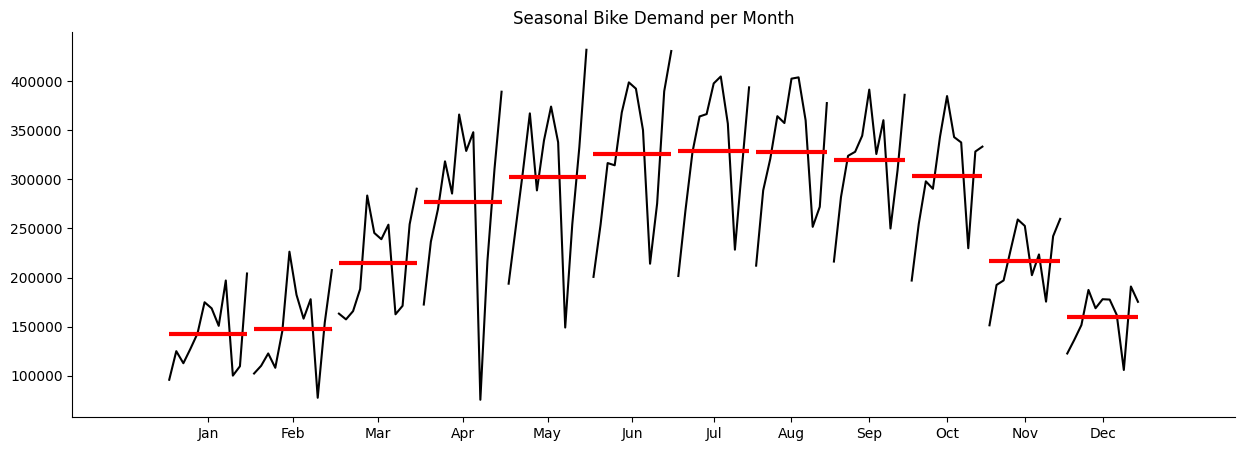

In [26]:
from statsmodels.graphics.tsaplots import month_plot

plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(bikeshare_data_monthly["total_demand"], ax=plt.gca())

plt.title("Seasonal Bike Demand per Month")
sns.despine()
plt.show()

**<span style='color: DarkRed'>Again, the seasonality and the impact of Covid are clearly highlighted. June, July and August seem to witness the highest demand every year. This graph also captures the sharp recovery of bike rentals post Covid.</span>**

In [27]:
# let's look at the weekly trend over time

bikeshare_data_weekly = bikeshare_data.copy()

bikeshare_data_weekly['weekday'] = bikeshare_data_weekly.index.dayofweek.values
bikeshare_data_weekly['year'] = bikeshare_data_weekly.index.year.values
bikeshare_data_weekly.weekday = np.where(bikeshare_data_weekly.weekday<5, 1, 0)
bikeshare_data_weekly.head()

member  casual  total_demand  weekday  year
2012-01-01  1572.0   688.0        2260.0        0  2012
2012-01-02  1693.0   244.0        1937.0        1  2012
2012-01-03  2130.0    89.0        2219.0        1  2012
2012-01-04  2262.0    95.0        2357.0        1  2012
2012-01-05  3111.0   140.0        3251.0        1  2012

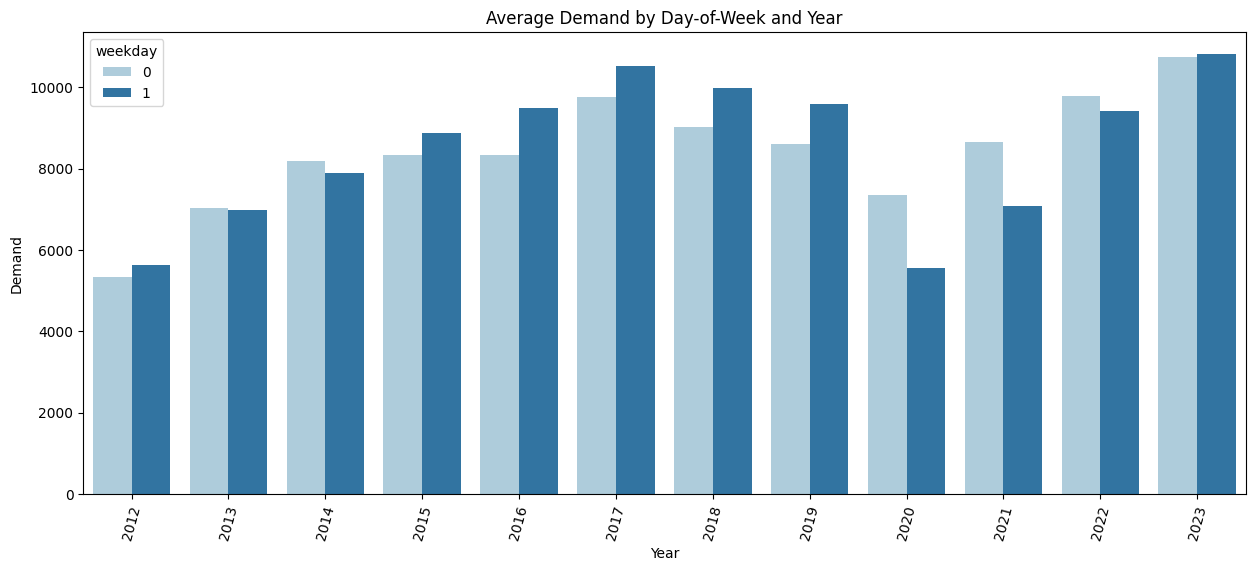

In [28]:
grouped_weekday_by_year = bikeshare_data_weekly.groupby(['year','weekday'])['total_demand'].sum()/\
bikeshare_data_weekly.groupby(['year','weekday'])['total_demand'].count()

grouped_weekday_by_year = grouped_weekday_by_year.reset_index()

# visualizing weekday-weekend trends

plt.figure(figsize=(15,6))
custom_palette = sns.color_palette("Paired")
sns.barplot(data=grouped_weekday_by_year, x='year', y='total_demand', hue='weekday', palette=custom_palette)
plt.xticks(rotation=75)
plt.ylabel('Demand')
plt.xlabel('Year')
plt.title('Average Demand by Day-of-Week and Year')
plt.show()

**<span style='color: DarkRed'>We can clearly see the increase in average demand as the years progress. The average bike demand during weekdays overtook the average demand over weekends in 2015 and stayed that way until the pandemic hit in 2020. The trend reversed during the pandemic years but we can see the average weekday demand overtaking the weekend demand by mid 2023 again.</span>**

<a id="4"></a>
### **2. Weather Data**

In [29]:
# loading data

weather_data = pd.read_csv('/Users/sonalkiranhansra/Desktop/BrainStation_Sonal/Classes/Capstone/data/noaa_weather_data/weather_dec2011_jul2023.csv')
display(weather_data.head(5))
print('\nData shape: ', weather_data.shape)
print('\nData Info:\n')
print(weather_data.info())

station                                       name        date  \
0  USC00182325                DALECARLIA RESERVOIR, MD US  31/12/2011   
1  USW00013743  WASHINGTON REAGAN NATIONAL AIRPORT, VA US  31/12/2011   
2  USC00186350               NATIONAL ARBORETUM DC, MD US  31/12/2011   
3  USC00182325                DALECARLIA RESERVOIR, MD US  01/01/2012   
4  USW00013743  WASHINGTON REAGAN NATIONAL AIRPORT, VA US  01/01/2012   

   avg_wind_speed  num_days_multiday_prcp  multiday_prcp  peak_gust_time  \
0             NaN                     NaN            NaN             NaN   
1            8.50                     NaN            NaN             NaN   
2             NaN                     NaN            NaN             NaN   
3             NaN                     NaN            NaN             NaN   
4            8.72                     NaN            NaN             NaN   

   prcp  snowfall  snowdepth  temp_avg  temp_max  temp_min  temp_obs  \
0   0.0       0.0        0.0       NaN      53.0      30.0      42.0   
1   0.0       0.0        0.0       NaN      62.0      46.0       NaN   
2   0.0       NaN        NaN       NaN      55.0      33.0      49.0   
3   0.0       0.0        0.0       NaN      53.0      34.0      36.0   
4   0.0       0.0        0.0       NaN      60.0      38.0       NaN   

   dir_fastest_2min_wind  dir_fastest_5min_wind  speed_fastest_2min_wind  \
0                    NaN                    NaN                      NaN   
1                  300.0                  330.0                     21.9   
2                    NaN                    NaN                      NaN   
3                    NaN                    NaN                      NaN   
4                  320.0                  310.0                     21.9   

   speed_fastest_5min_wind  wt_fog  wt_heavy_fog  wt_thunder  wt_sleet  \
0                      NaN     NaN           NaN         NaN       NaN   
1                     28.0     NaN           NaN         NaN       NaN   
2                      NaN     NaN           NaN         NaN       NaN   
3                      NaN     NaN           NaN         NaN       NaN   
4                     29.1     1.0           NaN         NaN       NaN   

   wt_hail  wt_glaze  wt_smoke  wt_drift_snow  wt_high_winds  wt_mist  \
0      NaN       NaN       NaN            NaN            NaN      NaN   
1      NaN       NaN       NaN            NaN            NaN      NaN   
2      NaN       NaN       NaN            NaN            NaN      NaN   
3      NaN       NaN       NaN            NaN            NaN      NaN   
4      NaN       NaN       NaN            NaN            NaN      NaN   

   wt_drizzle  wt_freeze_drizzle  wt_rain  wt_freeze_rain  wt_snow  \
0         NaN                NaN      NaN             NaN      NaN   
1         NaN                NaN      1.0             NaN      NaN   
2         NaN                NaN      NaN             NaN      NaN   
3         NaN                NaN      NaN             NaN      NaN   
4         NaN                NaN      1.0             NaN      NaN   

   wt_ground_fog  wt_freeze_fog  
0            NaN            NaN  
1            NaN            NaN  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN


Data shape:  (12323, 35)

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12323 entries, 0 to 12322
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   station                  12323 non-null  object 
 1   name                     12323 non-null  object 
 2   date                     12323 non-null  object 
 3   avg_wind_speed           4222 non-null   float64
 4   num_days_multiday_prcp   35 non-null     float64
 5   multiday_prcp            35 non-null     float64
 6   peak_gust_time           1 non-null      float64
 7   prcp                     12213 non-null  float64
 8   snowfall                 10940 non-null  float64
 9   snowdepth                10834 non-null  float64
 10  temp_avg                 3521 non-null   float64
 11  temp_max                 12070 non-null  float64
 12  temp_min                 12137 non-null  float64
 13  temp_obs                 8010 non-nul

**<span style='color: DarkRed;'>We know from Step 1 that we have observations from 3 stations informing the weather data for any given day. We will have to group this data by date to be able to use it for our timeseries model. Which means we have to figure out the best way to merge data from the 3 different stations. We also need to change the data type of the `date` column from 'object' to 'datetime'.</span>**

In [30]:
# looking at data info and description
      
print('\nData Description: \n')
display(weather_data.describe())

print('\nData Info: \n')
display(weather_data.info())


Data Description: 



avg_wind_speed  num_days_multiday_prcp  multiday_prcp  peak_gust_time  \
count     4222.000000               35.000000      35.000000             1.0   
mean         8.415047                2.142857       0.500000          1235.0   
std          3.269214                0.355036       0.645723             NaN   
min          1.120000                2.000000       0.000000          1235.0   
25%          6.040000                2.000000       0.000000          1235.0   
50%          7.830000                2.000000       0.170000          1235.0   
75%         10.290000                2.000000       0.930000          1235.0   
max         29.970000                3.000000       2.200000          1235.0   

               prcp      snowfall     snowdepth     temp_avg      temp_max  \
count  12213.000000  10940.000000  10834.000000  3521.000000  12070.000000   
mean       0.128017      0.031197      0.058667    59.938938     67.912262   
std        0.349117      0.372567      0.628126    16.710128     17.973042   
min        0.000000      0.000000      0.000000    13.000000     12.000000   
25%        0.000000      0.000000      0.000000    46.000000     53.000000   
50%        0.000000      0.000000      0.000000    61.000000     70.000000   
75%        0.060000      0.000000      0.000000    75.000000     84.000000   
max        4.800000     14.000000     22.000000    91.000000    105.000000   

           temp_min     temp_obs  dir_fastest_2min_wind  \
count  12137.000000  8010.000000            4222.000000   
mean      49.313339    53.328090             217.726196   
std       16.963855    17.039896             107.355156   
min        2.000000     4.000000              10.000000   
25%       35.000000    39.000000             160.000000   
50%       49.000000    54.000000             210.000000   
75%       65.000000    69.000000             320.000000   
max       83.000000    89.000000             360.000000   

       dir_fastest_5min_wind  speed_fastest_2min_wind  \
count            4214.000000              4222.000000   
mean              220.401044                19.211819   
std               105.791493                 6.285189   
min                10.000000                 6.000000   
25%               160.000000                15.000000   
50%               220.000000                17.900000   
75%               320.000000                23.000000   
max               360.000000                52.100000   

       speed_fastest_5min_wind  wt_fog  wt_heavy_fog  wt_thunder  wt_sleet  \
count              4214.000000  1207.0         101.0       447.0      50.0   
mean                 25.076270     1.0           1.0         1.0       1.0   
std                   8.903236     0.0           0.0         0.0       0.0   
min                   6.900000     1.0           1.0         1.0       1.0   
25%                  18.100000     1.0           1.0         1.0       1.0   
50%                  23.000000     1.0           1.0         1.0       1.0   
75%                  30.000000     1.0           1.0         1.0       1.0   
max                  70.000000     1.0           1.0         1.0       1.0   

       wt_hail  wt_glaze  wt_smoke  wt_drift_snow  wt_high_winds  wt_mist  \
count      7.0      21.0     379.0            3.0           10.0    123.0   
mean       1.0       1.0       1.0            1.0            1.0      1.0   
std        0.0       0.0       0.0            0.0            0.0      0.0   
min        1.0       1.0       1.0            1.0            1.0      1.0   
25%        1.0       1.0       1.0            1.0            1.0      1.0   
50%        1.0       1.0       1.0            1.0            1.0      1.0   
75%        1.0       1.0       1.0            1.0            1.0      1.0   
max        1.0       1.0       1.0            1.0            1.0      1.0   

       wt_drizzle  wt_freeze_drizzle  wt_rain  wt_freeze_rain  wt_snow  \
count        46.0                2.0    193.0             1.0     


Data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12323 entries, 0 to 12322
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   station                  12323 non-null  object 
 1   name                     12323 non-null  object 
 2   date                     12323 non-null  object 
 3   avg_wind_speed           4222 non-null   float64
 4   num_days_multiday_prcp   35 non-null     float64
 5   multiday_prcp            35 non-null     float64
 6   peak_gust_time           1 non-null      float64
 7   prcp                     12213 non-null  float64
 8   snowfall                 10940 non-null  float64
 9   snowdepth                10834 non-null  float64
 10  temp_avg                 3521 non-null   float64
 11  temp_max                 12070 non-null  float64
 12  temp_min                 12137 non-null  float64
 13  temp_obs                 8010 non-null   float64
 14  dir_fast

None

In [31]:
# converting `date` column's datatype to datetime

weather_data['date'] = pd.to_datetime(weather_data['date'])
print('Date column data type: ', weather_data['date'].dtype)

Date column data type:  datetime64[ns]


**<span style='color: DarkRed;'>We don't require all the columns in the weather dataset. Let's remove the columns we don't need, along with any weather columns with less than 10 non-null values. We'll then group by `date` and impute the missing values.</span>**

In [32]:
# removing columns which are not requied for our analysis

columns_to_remove = ['station', 'name', 'num_days_multiday_prcp', 'multiday_prcp', 'peak_gust_time', 'snowdepth',
                'dir_fastest_2min_wind', 'dir_fastest_5min_wind', 'wt_hail', 'wt_drift_snow', 'wt_freeze_drizzle',
                'wt_freeze_rain', 'wt_ground_fog', 'wt_freeze_fog']

cleaned_weather_data = weather_data.drop(columns=columns_to_remove, axis=1)

# verifying

display(cleaned_weather_data.head())
print(cleaned_weather_data.info())

date  avg_wind_speed  prcp  snowfall  temp_avg  temp_max  temp_min  \
0 2011-12-31             NaN   0.0       0.0       NaN      53.0      30.0   
1 2011-12-31            8.50   0.0       0.0       NaN      62.0      46.0   
2 2011-12-31             NaN   0.0       NaN       NaN      55.0      33.0   
3 2012-01-01             NaN   0.0       0.0       NaN      53.0      34.0   
4 2012-01-01            8.72   0.0       0.0       NaN      60.0      38.0   

   temp_obs  speed_fastest_2min_wind  speed_fastest_5min_wind  wt_fog  \
0      42.0                      NaN                      NaN     NaN   
1       NaN                     21.9                     28.0     NaN   
2      49.0                      NaN                      NaN     NaN   
3      36.0                      NaN                      NaN     NaN   
4       NaN                     21.9                     29.1     1.0   

   wt_heavy_fog  wt_thunder  wt_sleet  wt_glaze  wt_smoke  wt_high_winds  \
0           NaN         NaN       NaN       NaN       NaN            NaN   
1           NaN         NaN       NaN       NaN       NaN            NaN   
2           NaN         NaN       NaN       NaN       NaN            NaN   
3           NaN         NaN       NaN       NaN       NaN            NaN   
4           NaN         NaN       NaN       NaN       NaN            NaN   

   wt_mist  wt_drizzle  wt_rain  wt_snow  
0      NaN         NaN      NaN      NaN  
1      NaN         NaN      1.0      NaN  
2      NaN         NaN      NaN      NaN  
3      NaN         NaN      NaN      NaN  
4      NaN         NaN      1.0      NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12323 entries, 0 to 12322
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     12323 non-null  datetime64[ns]
 1   avg_wind_speed           4222 non-null   float64       
 2   prcp                     12213 non-null  float64       
 3   snowfall                 10940 non-null  float64       
 4   temp_avg                 3521 non-null   float64       
 5   temp_max                 12070 non-null  float64       
 6   temp_min                 12137 non-null  float64       
 7   temp_obs                 8010 non-null   float64       
 8   speed_fastest_2min_wind  4222 non-null   float64       
 9   speed_fastest_5min_wind  4214 non-null   float64       
 10  wt_fog                   1207 non-null   float64       
 11  wt_heavy_fog             101 non-null    float64       
 12  wt_thunder               447 non

**<span style='color: DarkRed;'>We are down to 21 columns from 35 columns! We will de-duplicate our data and merge data from 3 different weather stations in two steps -</span>**

**<span style='color: DarkRed;'>1. Weather type columns (`wt_`): They contain either `0`, `1` or `NaN`. We will fill all the `NaN` values with `0` and while grouping data by date we'll keep the max value in each weather column so that we can retain the `1` where it is present.</span>**

**<span style='color: DarkRed;'>2. Non weather type columns: They contain a range of numerical values. While grouping data by date, we'll take an average of the non-null values.</span>**

**Addressing point 1 : Weather-Type Columns**

In [33]:
# selecting weather type columns

weather_type_cols = [col for col in cleaned_weather_data.columns if col[:2]=='wt']
weather_type_cols.append('date')

# replacing `NaN` with 0

cleaned_weather_data_wt = cleaned_weather_data[weather_type_cols]
print('Before imputation:\n\n',cleaned_weather_data_wt.isna().sum())
cleaned_weather_data_wt.fillna(0, inplace=True)
print('\nAfter imputation:\n\n',cleaned_weather_data_wt.isna().sum())

Before imputation:

 wt_fog           11116
wt_heavy_fog     12222
wt_thunder       11876
wt_sleet         12273
wt_glaze         12302
wt_smoke         11944
wt_high_winds    12313
wt_mist          12200
wt_drizzle       12277
wt_rain          12130
wt_snow          12288
date                 0
dtype: int64

After imputation:

 wt_fog           0
wt_heavy_fog     0
wt_thunder       0
wt_sleet         0
wt_glaze         0
wt_smoke         0
wt_high_winds    0
wt_mist          0
wt_drizzle       0
wt_rain          0
wt_snow          0
date             0
dtype: int64


In [34]:
# grouping weather data

cleaned_weather_data_wt = cleaned_weather_data_wt.groupby('date', as_index=False).max()
cleaned_weather_data_wt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4223 entries, 0 to 4222
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4223 non-null   datetime64[ns]
 1   wt_fog         4223 non-null   float64       
 2   wt_heavy_fog   4223 non-null   float64       
 3   wt_thunder     4223 non-null   float64       
 4   wt_sleet       4223 non-null   float64       
 5   wt_glaze       4223 non-null   float64       
 6   wt_smoke       4223 non-null   float64       
 7   wt_high_winds  4223 non-null   float64       
 8   wt_mist        4223 non-null   float64       
 9   wt_drizzle     4223 non-null   float64       
 10  wt_rain        4223 non-null   float64       
 11  wt_snow        4223 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 396.0 KB


**<span style='color: DarkRed;'>Now let's look at the correlation between these columns. Since these are binary columns, Phi Coefficient (or Matthew's Correlation Coefficient) should be a good metric to understand relationship between these variables. Since Pearson correlation coefficient estimated for two binary variables will return the Phi coefficient, let's go ahead and calculate Pearson's coefficient and plot the same.</span>**

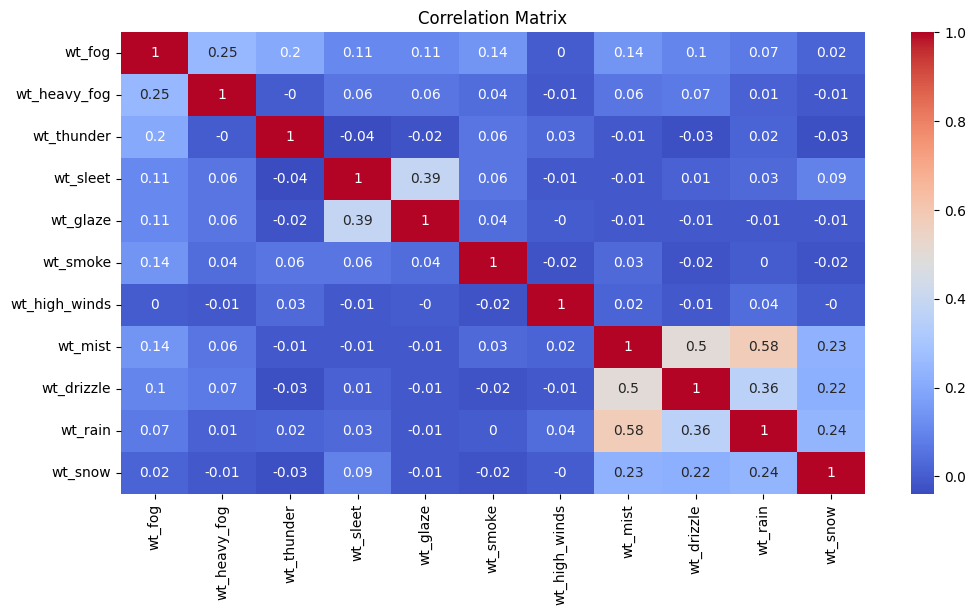

In [35]:
from sklearn.metrics import matthews_corrcoef

weather_type_cols = [col for col in cleaned_weather_data_wt.columns]
weather_type_cols.remove('date')

'''
# calculating Matthews Corr Coeff
wt_corr = {}

num_cols = len(weather_type_cols)
for i in range(num_cols):
    for j in range(i+1, num_cols):
        col_1 = weather_type_cols[i]
        col_2 = weather_type_cols[j]
        wt_corr[(col_1, col_2)] = matthews_corrcoef(cleaned_weather_data_wt[col_1], cleaned_weather_data_wt[col_2])
'''
plt.figure(figsize=(12, 6))
sns.heatmap(cleaned_weather_data_wt[weather_type_cols].corr().round(2), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

**<span style='color: DarkRed;'>Since there are no significant correlations between these variables, we will retain all of them for now.</span>**

**Addressing Point 2 : Non Weather-Type Columns**

In [36]:
# selecting non weather type columns

non_weather_type_cols = [col for col in cleaned_weather_data.columns if col[:2]!='wt']
cleaned_weather_data_non_wt = cleaned_weather_data[non_weather_type_cols]
cleaned_weather_data_non_wt.head(10)

date  avg_wind_speed  prcp  snowfall  temp_avg  temp_max  temp_min  \
0 2011-12-31             NaN  0.00       0.0       NaN      53.0      30.0   
1 2011-12-31            8.50  0.00       0.0       NaN      62.0      46.0   
2 2011-12-31             NaN  0.00       NaN       NaN      55.0      33.0   
3 2012-01-01             NaN  0.00       0.0       NaN      53.0      34.0   
4 2012-01-01            8.72  0.00       0.0       NaN      60.0      38.0   
5 2012-01-01             NaN  0.00       NaN       NaN      60.0      34.0   
6 2012-01-02             NaN  0.06       0.0       NaN      58.0      34.0   
7 2012-01-02           13.87  0.00       0.0       NaN      49.0      32.0   
8 2012-01-02             NaN  0.00       NaN       NaN      61.0      34.0   
9 2012-01-03             NaN  0.00       0.0       NaN      58.0      28.0   

   temp_obs  speed_fastest_2min_wind  speed_fastest_5min_wind  
0      42.0                      NaN                      NaN  
1       NaN                     21.9                     28.0  
2      49.0                      NaN                      NaN  
3      36.0                      NaN                      NaN  
4       NaN                     21.9                     29.1  
5      40.0                      NaN                      NaN  
6      35.0                      NaN                      NaN  
7       NaN                     31.1                     40.0  
8      34.0                      NaN                      NaN  
9      28.0                      NaN                      NaN

In [37]:
# grouping by date and taking mean of non-null values

cleaned_weather_data_non_wt = cleaned_weather_data_non_wt.groupby('date', as_index=False).mean()
print('Percentage missing values after grrouping by date -')
cleaned_weather_data_non_wt.isna().sum()/cleaned_weather_data_non_wt.count()*100

Percentage missing values after grrouping by date -


date                        0.000000
avg_wind_speed              0.023685
prcp                        0.023685
snowfall                    0.023685
temp_avg                   19.937518
temp_max                    0.023685
temp_min                    0.023685
temp_obs                    1.465642
speed_fastest_2min_wind     0.023685
speed_fastest_5min_wind     0.213574
dtype: float64

**<span style='color: DarkRed;'>We still have some missing values. Since this is weather data, it is safe to assume that the neither of these values would change drastically from one day to another. Hence, we'll employ the Last Observation Carried Forward (LOCF) imputation method.</span>**

In [38]:
# imputing missing data 

cleaned_weather_data_non_wt=cleaned_weather_data_non_wt.sort_index().fillna(method='ffill')
print('Percentage missing data after imputation -\n')
cleaned_weather_data_non_wt.isna().sum()/cleaned_weather_data_non_wt.count()*100

Percentage missing data after imputation -



date                        0.000000
avg_wind_speed              0.000000
prcp                        0.000000
snowfall                    0.000000
temp_avg                   12.134891
temp_max                    0.000000
temp_min                    0.000000
temp_obs                    0.000000
speed_fastest_2min_wind     0.000000
speed_fastest_5min_wind     0.000000
dtype: float64

**<span style='color: DarkRed;'>Before spending more time imputing data, let's first look at the correlation between all the non weather type columns and figure out which columns should be kept.</span>**

Text(0.5, 1.0, 'Correlation Matrix')

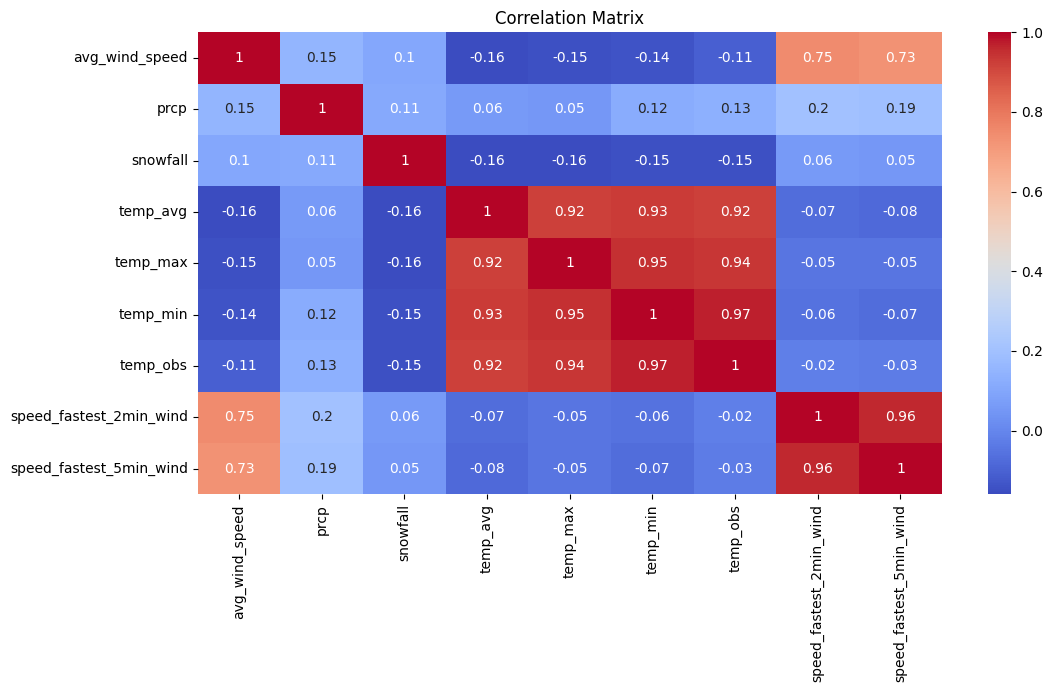

In [39]:
# plotting correlation

plt.figure(figsize=(12, 6))
sns.heatmap(cleaned_weather_data_non_wt.drop(columns='date').corr().round(2), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')

**<span style='color: DarkRed;'>We can see very high correlation between all the temperature columns as well as between all the wind columns. This is expected. to prevent collinearity in our data let's go ahead and delete all but one of the temperature and wind columns.</span>**

In [40]:
# dropping columns to prevent collinearity

cols_to_drop = ['temp_avg', 'temp_max', 'temp_min', 'speed_fastest_2min_wind', 'speed_fastest_5min_wind']
cleaned_weather_data_non_wt.drop(columns=cols_to_drop, inplace=True)
cleaned_weather_data_non_wt.head()

date  avg_wind_speed  prcp  snowfall  temp_obs
0 2011-12-31            8.50  0.00       0.0      45.5
1 2012-01-01            8.72  0.00       0.0      38.0
2 2012-01-02           13.87  0.02       0.0      34.5
3 2012-01-03           15.66  0.00       0.0      28.5
4 2012-01-04            7.61  0.00       0.0      18.0

In [41]:
cleaned_weather_data_non_wt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4223 entries, 0 to 4222
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            4223 non-null   datetime64[ns]
 1   avg_wind_speed  4223 non-null   float64       
 2   prcp            4223 non-null   float64       
 3   snowfall        4223 non-null   float64       
 4   temp_obs        4223 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 165.1 KB


**<span style='color: DarkRed;'>Now let's combine the two weather data sub-sets and create our final cleaned weather dataset. We will be joining the datasets based on dates, so let's begin by setting the `date` column as index</span>**

In [42]:
# setting `date` as inidex

cleaned_weather_data_wt.set_index('date', inplace=True)
cleaned_weather_data_non_wt.set_index('date', inplace=True)

# joining the two datasets

cleaned_weather_data = cleaned_weather_data_non_wt.join(cleaned_weather_data_wt)

display(cleaned_weather_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4223 entries, 2011-12-31 to 2023-07-23
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   avg_wind_speed  4223 non-null   float64
 1   prcp            4223 non-null   float64
 2   snowfall        4223 non-null   float64
 3   temp_obs        4223 non-null   float64
 4   wt_fog          4223 non-null   float64
 5   wt_heavy_fog    4223 non-null   float64
 6   wt_thunder      4223 non-null   float64
 7   wt_sleet        4223 non-null   float64
 8   wt_glaze        4223 non-null   float64
 9   wt_smoke        4223 non-null   float64
 10  wt_high_winds   4223 non-null   float64
 11  wt_mist         4223 non-null   float64
 12  wt_drizzle      4223 non-null   float64
 13  wt_rain         4223 non-null   float64
 14  wt_snow         4223 non-null   float64
dtypes: float64(15)
memory usage: 656.9 KB


None

<a id="5"></a>
### **3. Holiday Data**

In [43]:
# we have already loaded holiday data, let's look at it in more detail

print('Data shape: ', holiday_data.shape)
print('\nData head\n')
display(holiday_data.head())
print('\nHoliday Data Info: \n')
display(holiday_data.info())

Data shape:  (4383, 4)

Data head



date  weekend  holiday  weekend_holiday
0 2012-01-01        1        0                1
1 2012-01-02        0        1                1
2 2012-01-03        0        0                0
3 2012-01-04        0        0                0
4 2012-01-05        0        0                0


Holiday Data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             4383 non-null   datetime64[ns]
 1   weekend          4383 non-null   int64         
 2   holiday          4383 non-null   int64         
 3   weekend_holiday  4383 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 137.1 KB


None

<a id="6"></a>
### **Combining All Datasets**

**<span style='color: DarkRed;'>We are now ready to combine all three datasets into one master dataset which we will use going forward for any further data explorartion and building our models.</span>**

In [44]:
# combining datasets

holiday_data.set_index('date', inplace=True)

combined_data = bikeshare_data.join([cleaned_weather_data, holiday_data])

print(combined_data.shape)
combined_data.head()


(4199, 21)


member  casual  total_demand  avg_wind_speed  prcp  snowfall  \
2012-01-01  1572.0   688.0        2260.0            8.72  0.00       0.0   
2012-01-02  1693.0   244.0        1937.0           13.87  0.02       0.0   
2012-01-03  2130.0    89.0        2219.0           15.66  0.00       0.0   
2012-01-04  2262.0    95.0        2357.0            7.61  0.00       0.0   
2012-01-05  3111.0   140.0        3251.0            4.92  0.00       0.0   

            temp_obs  wt_fog  wt_heavy_fog  wt_thunder  wt_sleet  wt_glaze  \
2012-01-01      38.0     1.0           0.0         0.0       0.0       0.0   
2012-01-02      34.5     0.0           0.0         0.0       0.0       0.0   
2012-01-03      28.5     0.0           0.0         0.0       0.0       0.0   
2012-01-04      18.0     0.0           0.0         0.0       0.0       0.0   
2012-01-05      32.5     0.0           0.0         0.0       0.0       0.0   

            wt_smoke  wt_high_winds  wt_mist  wt_drizzle  wt_rain  wt_snow  \
2012-01-01       0.0            0.0      0.0         0.0      1.0      0.0   
2012-01-02       0.0            0.0      0.0         0.0      0.0      0.0   
2012-01-03       0.0            0.0      0.0         0.0      0.0      1.0   
2012-01-04       0.0            0.0      0.0         0.0      0.0      0.0   
2012-01-05       1.0            0.0      0.0         0.0      0.0      0.0   

            weekend  holiday  weekend_holiday  
2012-01-01      1.0      0.0              1.0  
2012-01-02      0.0      1.0              1.0  
2012-01-03      0.0      0.0              0.0  
2012-01-04      0.0      0.0              0.0  
2012-01-05      0.0      0.0              0.0

In [45]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4199 entries, 2012-01-01 to 2023-06-30
Freq: D
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   member           4199 non-null   float64
 1   casual           4199 non-null   float64
 2   total_demand     4199 non-null   float64
 3   avg_wind_speed   4199 non-null   float64
 4   prcp             4199 non-null   float64
 5   snowfall         4199 non-null   float64
 6   temp_obs         4199 non-null   float64
 7   wt_fog           4199 non-null   float64
 8   wt_heavy_fog     4199 non-null   float64
 9   wt_thunder       4199 non-null   float64
 10  wt_sleet         4199 non-null   float64
 11  wt_glaze         4199 non-null   float64
 12  wt_smoke         4199 non-null   float64
 13  wt_high_winds    4199 non-null   float64
 14  wt_mist          4199 non-null   float64
 15  wt_drizzle       4199 non-null   float64
 16  wt_rain          4199 non-null   f

<a id="7"></a>
### **Feature Engineering**

**<span style='color: DarkRed;'>Our target variable is `total_demand` and we are not trying to predict demand by rider type so we will go ahead and  drop the `member` and `casual` columns.</span>**

In [46]:
# dropping rider type columns

combined_data = combined_data.drop(columns=['member', 'casual'])
combined_data.head()

total_demand  avg_wind_speed  prcp  snowfall  temp_obs  wt_fog  \
2012-01-01        2260.0            8.72  0.00       0.0      38.0     1.0   
2012-01-02        1937.0           13.87  0.02       0.0      34.5     0.0   
2012-01-03        2219.0           15.66  0.00       0.0      28.5     0.0   
2012-01-04        2357.0            7.61  0.00       0.0      18.0     0.0   
2012-01-05        3251.0            4.92  0.00       0.0      32.5     0.0   

            wt_heavy_fog  wt_thunder  wt_sleet  wt_glaze  wt_smoke  \
2012-01-01           0.0         0.0       0.0       0.0       0.0   
2012-01-02           0.0         0.0       0.0       0.0       0.0   
2012-01-03           0.0         0.0       0.0       0.0       0.0   
2012-01-04           0.0         0.0       0.0       0.0       0.0   
2012-01-05           0.0         0.0       0.0       0.0       1.0   

            wt_high_winds  wt_mist  wt_drizzle  wt_rain  wt_snow  weekend  \
2012-01-01            0.0      0.0         0.0      1.0      0.0      1.0   
2012-01-02            0.0      0.0         0.0      0.0      0.0      0.0   
2012-01-03            0.0      0.0         0.0      0.0      1.0      0.0   
2012-01-04            0.0      0.0         0.0      0.0      0.0      0.0   
2012-01-05            0.0      0.0         0.0      0.0      0.0      0.0   

            holiday  weekend_holiday  
2012-01-01      0.0              1.0  
2012-01-02      1.0              1.0  
2012-01-03      0.0              0.0  
2012-01-04      0.0              0.0  
2012-01-05      0.0              0.0

**<span style='color: DarkRed;'>We have seen that our data shows seasonality, which is expected. To be able to capture the effects of seasonality better, let's create new columns for each quarter.</span>**

In [47]:
# creating new columns for each quarter

ohe = OneHotEncoder()
encoded_qt = ohe.fit_transform(combined_data.index.quarter.values.reshape(-1,1))
encoded_qt.toarray()

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [48]:
# adding to combined_data dataframe

categories = ['qt_' + str(val) for val in ohe.categories_[0]]
print(categories)

qt_df = pd.DataFrame(encoded_qt.toarray(), columns=categories, index=combined_data.index)
combined_data = combined_data.join(qt_df)
combined_data.sample(5)

['qt_1', 'qt_2', 'qt_3', 'qt_4']


total_demand  avg_wind_speed      prcp  snowfall  temp_obs  \
2022-04-04        8705.0            7.16  0.000000       0.0      36.5   
2023-03-17        9102.0           12.08  0.006667       0.0      50.5   
2016-05-28       11560.0            9.62  0.000000       0.0      73.5   
2015-12-07        7928.0            5.37  0.000000       0.0      42.5   
2018-07-25        9661.0            6.71  0.423333       0.0      74.5   

            wt_fog  wt_heavy_fog  wt_thunder  wt_sleet  wt_glaze  wt_smoke  \
2022-04-04     0.0           0.0         0.0       0.0       0.0       0.0   
2023-03-17     0.0           0.0         0.0       0.0       0.0       0.0   
2016-05-28     0.0           0.0         0.0       0.0       0.0       0.0   
2015-12-07     1.0           0.0         0.0       0.0       0.0       0.0   
2018-07-25     1.0           0.0         1.0       0.0       0.0       0.0   

            wt_high_winds  wt_mist  wt_drizzle  wt_rain  wt_snow  weekend  \
2022-04-04            0.0      0.0         0.0      0.0      0.0      0.0   
2023-03-17            0.0      0.0         0.0      0.0      0.0      0.0   
2016-05-28            0.0      0.0         0.0      0.0      0.0      1.0   
2015-12-07            0.0      0.0         0.0      0.0      0.0      0.0   
2018-07-25            0.0      0.0         0.0      0.0      0.0      0.0   

            holiday  weekend_holiday  qt_1  qt_2  qt_3  qt_4  
2022-04-04      0.0              0.0   0.0   1.0   0.0   0.0  
2023-03-17      0.0              0.0   1.0   0.0   0.0   0.0  
2016-05-28      0.0              1.0   0.0   1.0   0.0   0.0  
2015-12-07      0.0              0.0   0.0   0.0   0.0   1.0  
2018-07-25      0.0              0.0   0.0   0.0   1.0   0.0

**<span style='color: DarkRed;'>For the weather type columns, we can look at combining them based on similarity in terms of the impact they have on bike rentals. Let's explore these columns.</span>**

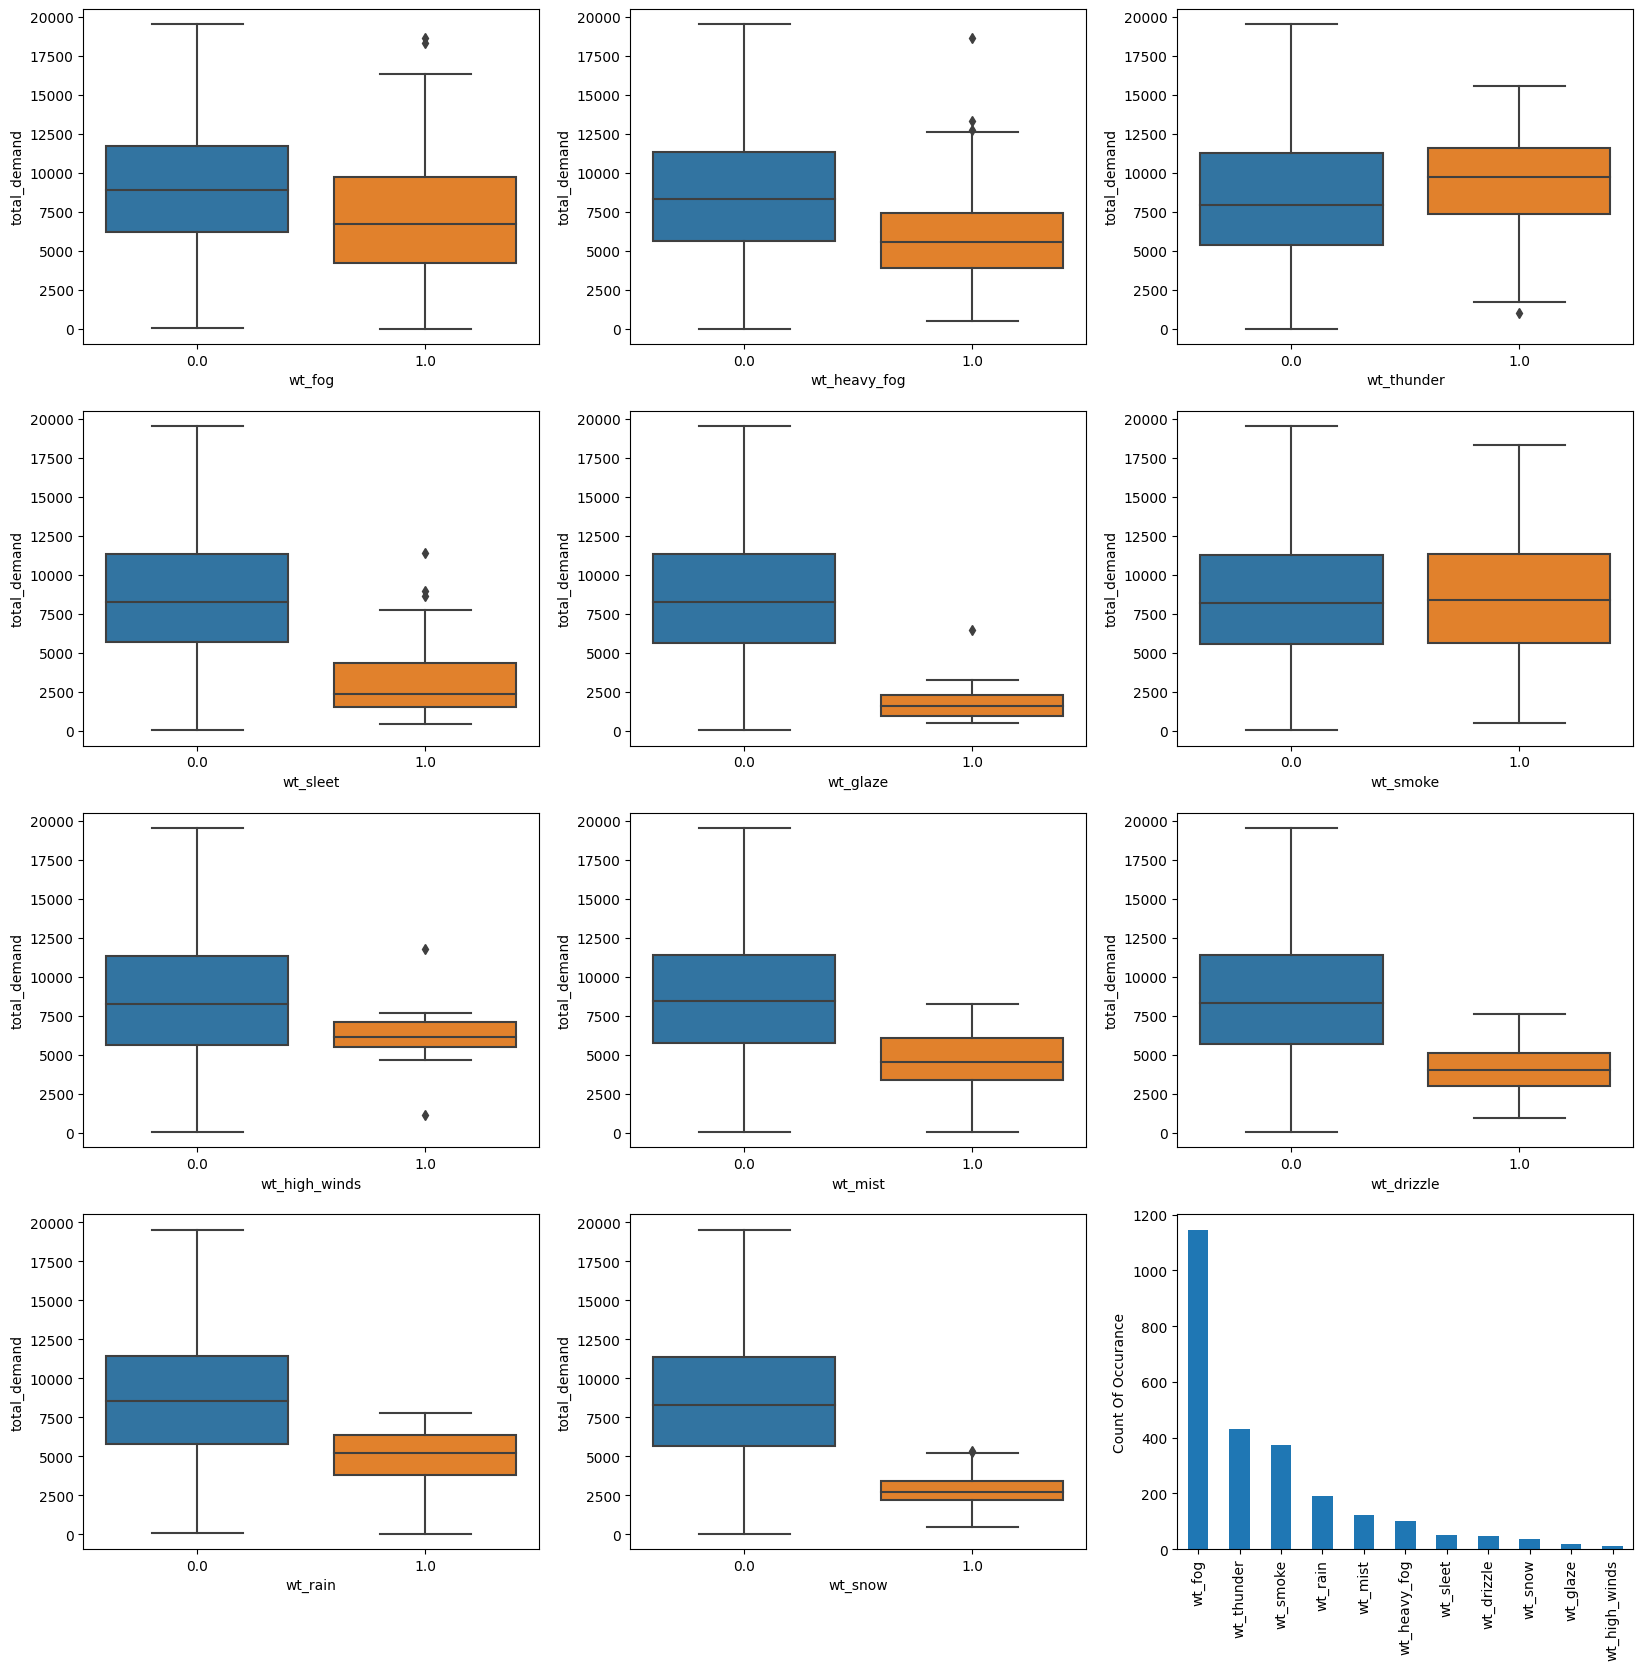

In [49]:
# plotting distribution of total_demand for every weather type column

wt_cols = ['wt_fog', 'wt_heavy_fog', 'wt_thunder', 'wt_sleet', 'wt_glaze',
           'wt_smoke', 'wt_high_winds', 'wt_mist', 'wt_drizzle', 'wt_rain','wt_snow']

plt.subplots(nrows = 4, ncols=3, figsize=(20, 20))
for i, col in enumerate(wt_cols):
    plt.subplot(4,3,i+1)
    sns.boxplot(data = combined_data, x=col,y='total_demand')
plt.subplot(4,3,12)
combined_data[wt_cols].sum().sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Count Of Occurance')
plt.show()    

**<span style='color: DarkRed;'>Based on the above distributions we can club the weather types as follows -.</span>**

**<span style='color: DarkRed;'>1. `fog`, `heavy_fog`, `smoke`</span>**

**<span style='color: DarkRed;'>2. `mist`, `drizzle`, `rain`</span>**

**<span style='color: DarkRed;'>3. `snow`, `glaze`, `sleet`</span>**

**<span style='color: DarkRed;'>4. `thunder`, `high_wind`</span>**

In [50]:
# combining weather type columns

combined_data['foggy'] = combined_data[['wt_fog', 'wt_heavy_fog', 'wt_smoke']].sum(axis=1).apply(lambda x: 0 if x==0 else 1)
combined_data['rainy'] = combined_data[['wt_mist', 'wt_drizzle', 'wt_rain']].sum(axis=1).apply(lambda x: 0 if x==0 else 1)
combined_data['snowy'] = combined_data[['wt_snow', 'wt_glaze', 'wt_sleet']].sum(axis=1).apply(lambda x: 0 if x==0 else 1)
combined_data['windy'] = combined_data[['wt_thunder', 'wt_high_winds']].sum(axis=1).apply(lambda x: 0 if x==0 else 1)

# dropping old weather type columns

combined_data.drop(columns=wt_cols, inplace=True)

# verifying

combined_data.sample(5)

total_demand  avg_wind_speed  prcp  snowfall  temp_obs  weekend  \
2012-03-21        6169.0            3.80  0.00       0.0      58.5      0.0   
2016-01-09        5314.0            4.70  0.09       0.0      40.5      1.0   
2020-12-21        3409.0            5.82  0.01       0.0      39.0      0.0   
2021-01-17        3745.0            9.40  0.00       0.0      36.5      1.0   
2020-03-06        6932.0            9.62  0.00       0.0      37.0      0.0   

            holiday  weekend_holiday  qt_1  qt_2  qt_3  qt_4  foggy  rainy  \
2012-03-21      0.0              0.0   1.0   0.0   0.0   0.0      1      1   
2016-01-09      0.0              1.0   1.0   0.0   0.0   0.0      1      0   
2020-12-21      0.0              0.0   0.0   0.0   0.0   1.0      1      0   
2021-01-17      0.0              1.0   1.0   0.0   0.0   0.0      0      0   
2020-03-06      0.0              0.0   1.0   0.0   0.0   0.0      0      0   

            snowy  windy  
2012-03-21      0      0  
2016-01-09      0      0  
2020-12-21      0      0  
2021-01-17      0      0  
2020-03-06      0      0

**<span style='color: DarkRed;'>Finally, let's plot the correlation matrix again and check the relationship between all of our independent variables.</span>**

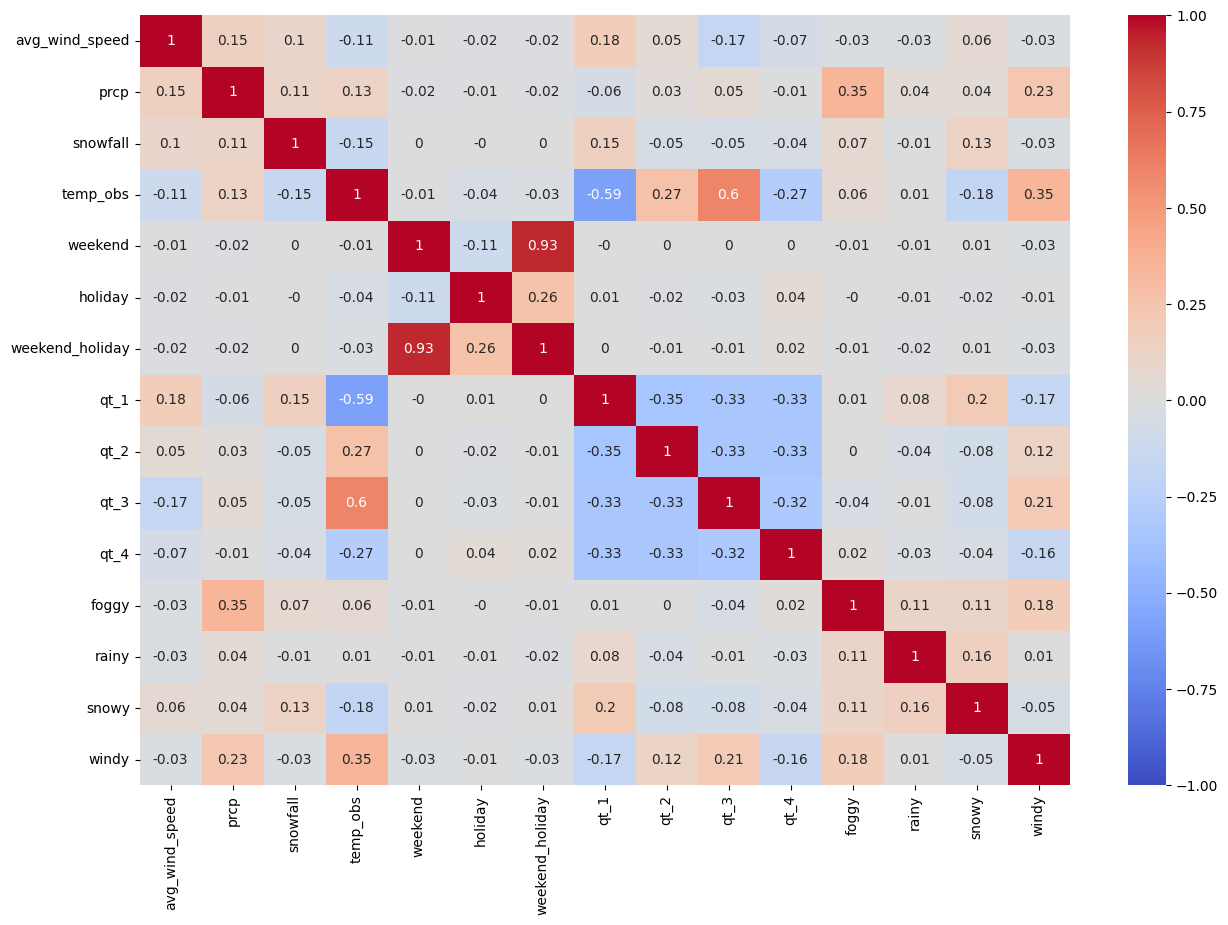

In [51]:
# plotting correlation matrix

plt.figure(figsize=(15,10))
sns.heatmap(combined_data.drop(columns='total_demand').corr().round(2), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.show()

**<span style='color: DarkRed;'>There is high correlation between the `weekend` and `weekend_holiday` columns. That is expected, so let's go ahead and drop one of them. But before we do that, we'll look at the distribution of our target variable `total_demand` for the weekend-holiday columns.</span>**

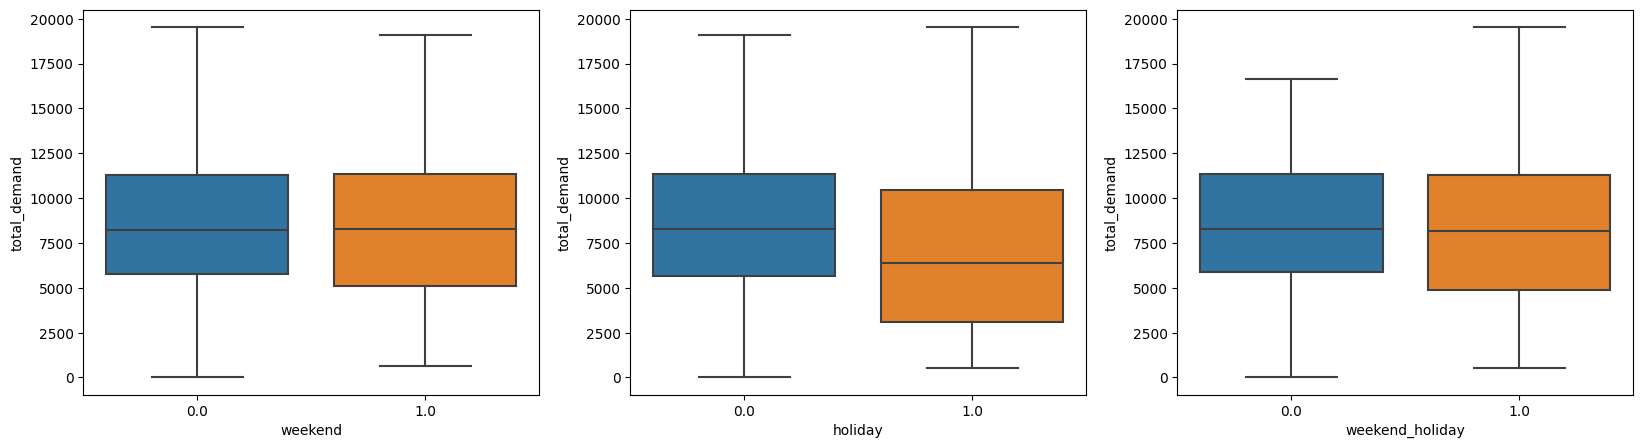

In [52]:
# plotting distribution of total_demand for weekend-holiday columns

wh_cols = ['weekend','holiday', 'weekend_holiday']

plt.subplots(nrows = 1, ncols=3, figsize=(20, 5))
for i, col in enumerate(wh_cols):
    plt.subplot(1,3,i+1)
    sns.boxplot(data = combined_data, x=col,y='total_demand')
plt.show() 

In [53]:
# let's go ahead and drop the weekend_holiday column

combined_data.drop(columns='weekend_holiday', inplace=True)
combined_data.head()

total_demand  avg_wind_speed  prcp  snowfall  temp_obs  weekend  \
2012-01-01        2260.0            8.72  0.00       0.0      38.0      1.0   
2012-01-02        1937.0           13.87  0.02       0.0      34.5      0.0   
2012-01-03        2219.0           15.66  0.00       0.0      28.5      0.0   
2012-01-04        2357.0            7.61  0.00       0.0      18.0      0.0   
2012-01-05        3251.0            4.92  0.00       0.0      32.5      0.0   

            holiday  qt_1  qt_2  qt_3  qt_4  foggy  rainy  snowy  windy  
2012-01-01      0.0   1.0   0.0   0.0   0.0      1      1      0      0  
2012-01-02      1.0   1.0   0.0   0.0   0.0      0      0      0      0  
2012-01-03      0.0   1.0   0.0   0.0   0.0      0      0      1      0  
2012-01-04      0.0   1.0   0.0   0.0   0.0      0      0      0      0  
2012-01-05      0.0   1.0   0.0   0.0   0.0      1      0      0      0

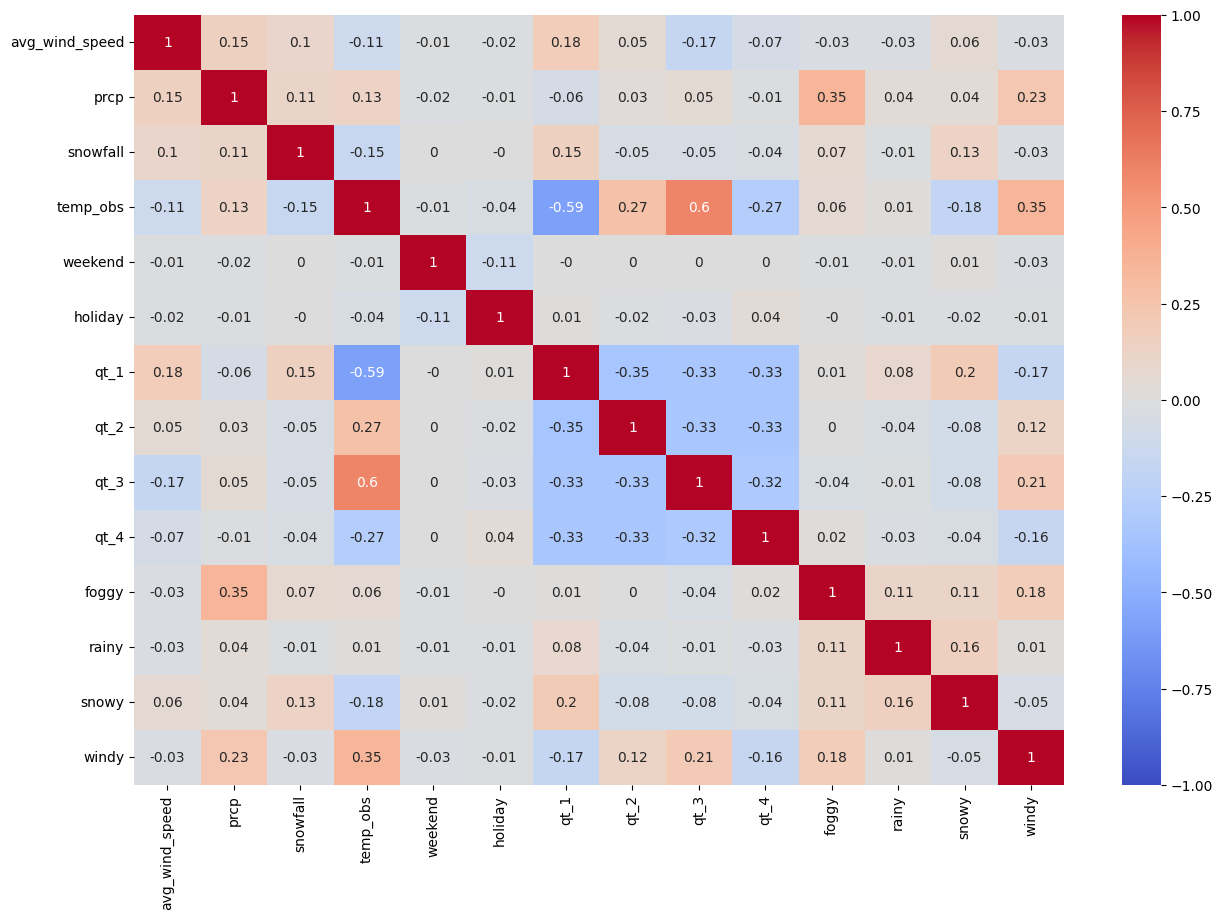

In [54]:
# plotting correlation matrix

plt.figure(figsize=(15,10))
sns.heatmap(combined_data.drop(columns='total_demand').corr().round(2), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.show()

<a id="8"></a>
### **Building Baseline Model**

<a id="9"></a>
### **Trend-Season Decomposition**

**<span style='color: DarkRed;'>To build a baseline model, it is important to first separate trend and seasonality from the data to evaluate which models would be appropriate.</span>** 

In [55]:
# decompose the time series at the month level

decomposition = tsa.seasonal_decompose(bikeshare_data_monthly['total_demand'], model='additive')
bikeshare_data_monthly["trend"] = decomposition.trend
bikeshare_data_monthly["seasonal"] = decomposition.seasonal
bikeshare_data_monthly["residual"] = decomposition.resid

bikeshare_data_monthly.head(10)

member   casual  total_demand          trend       seasonal  \
2012-01-31   86901.0   8970.0       95871.0            NaN -111905.734059   
2012-02-29   93526.0   8708.0      102234.0            NaN -107991.813226   
2012-03-31  131605.0  31605.0      163210.0            NaN  -43586.350726   
2012-04-30  134021.0  38454.0      172475.0            NaN   18570.886774   
2012-05-31  149494.0  44224.0      193718.0            NaN   42078.474274   
2012-06-30  157379.0  43256.0      200635.0            NaN   68647.895107   
2012-07-31  159857.0  41699.0      201556.0  170287.666667   78162.601926   
2012-08-31  168903.0  43190.0      212093.0  171828.666667   76415.014804   
2012-09-30  172491.0  43773.0      216264.0  171913.000000   66994.495865   
2012-10-31  162378.0  34521.0      196899.0  174334.791667   49581.874653   

                residual  
2012-01-31           NaN  
2012-02-29           NaN  
2012-03-31           NaN  
2012-04-30           NaN  
2012-05-31           NaN  
2012-06-30           NaN  
2012-07-31 -46894.268592  
2012-08-31 -36150.681471  
2012-09-30 -22643.495865  
2012-10-31 -27017.666319

In [56]:
# plotting the trend, seasonality and residual at the month level

cols = ["trend", "seasonal", "residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=bikeshare_data_monthly.index, y=bikeshare_data_monthly[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

**The seasonality captured here is the `monthly` seasonality.**

In [57]:
# decompose the time series at the day level

decomposition = tsa.seasonal_decompose(combined_data['total_demand'], model='additive')
combined_data["trend"] = decomposition.trend
combined_data["seasonal"] = decomposition.seasonal
combined_data["residual"] = decomposition.resid

combined_data.head(10)

total_demand  avg_wind_speed      prcp  snowfall  temp_obs  \
2012-01-01        2260.0            8.72  0.000000       0.0      38.0   
2012-01-02        1937.0           13.87  0.020000       0.0      34.5   
2012-01-03        2219.0           15.66  0.000000       0.0      28.5   
2012-01-04        2357.0            7.61  0.000000       0.0      18.0   
2012-01-05        3251.0            4.92  0.000000       0.0      32.5   
2012-01-06        4054.0            7.38  0.000000       0.0      37.0   
2012-01-07        4480.0            7.61  0.000000       0.0      39.5   
2012-01-08        3408.0            8.05  0.000000       0.0      38.5   
2012-01-09        2325.0            3.80  0.053333       0.2      32.5   
2012-01-10        3573.0            6.71  0.083333       0.0      32.5   

            weekend  holiday  qt_1  qt_2  qt_3  qt_4  foggy  rainy  snowy  \
2012-01-01      1.0      0.0   1.0   0.0   0.0   0.0      1      1      0   
2012-01-02      0.0      1.0   1.0   0.0   0.0   0.0      0      0      0   
2012-01-03      0.0      0.0   1.0   0.0   0.0   0.0      0      0      1   
2012-01-04      0.0      0.0   1.0   0.0   0.0   0.0      0      0      0   
2012-01-05      0.0      0.0   1.0   0.0   0.0   0.0      1      0      0   
2012-01-06      0.0      0.0   1.0   0.0   0.0   0.0      0      0      0   
2012-01-07      1.0      0.0   1.0   0.0   0.0   0.0      1      0      0   
2012-01-08      1.0      0.0   1.0   0.0   0.0   0.0      0      0      0   
2012-01-09      0.0      0.0   1.0   0.0   0.0   0.0      1      1      1   
2012-01-10      0.0      0.0   1.0   0.0   0.0   0.0      1      1      0   

            windy        trend    seasonal    residual  
2012-01-01      0          NaN -509.813465         NaN  
2012-01-02      0          NaN -442.236312         NaN  
2012-01-03      0          NaN   -5.062213         NaN  
2012-01-04      0  2936.857143  207.465095 -787.322238  
2012-01-05      0  3100.857143  105.819972   44.322885  
2012-01-06      0  3156.285714  209.416204  688.298082  
2012-01-07      0  3349.714286  434.410719  695.874996  
2012-01-08      0  3322.428571 -509.813465  595.384893  
2012-01-09      0  3438.428571 -442.236312 -671.192259  
2012-01-10      0  3315.000000   -5.062213  263.062213

In [58]:
# plotting the trend, seasonality and residual at the day level

cols = ["trend", "seasonal", "residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=combined_data.index, y=combined_data[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()
# fig.write_html('/Users/sonalkiranhansra/Desktop/BrainStation_Sonal/Classes/Capstone/plots/daily_decomp.html')

**The seasonality captured here is the `weekly` seasonality.**

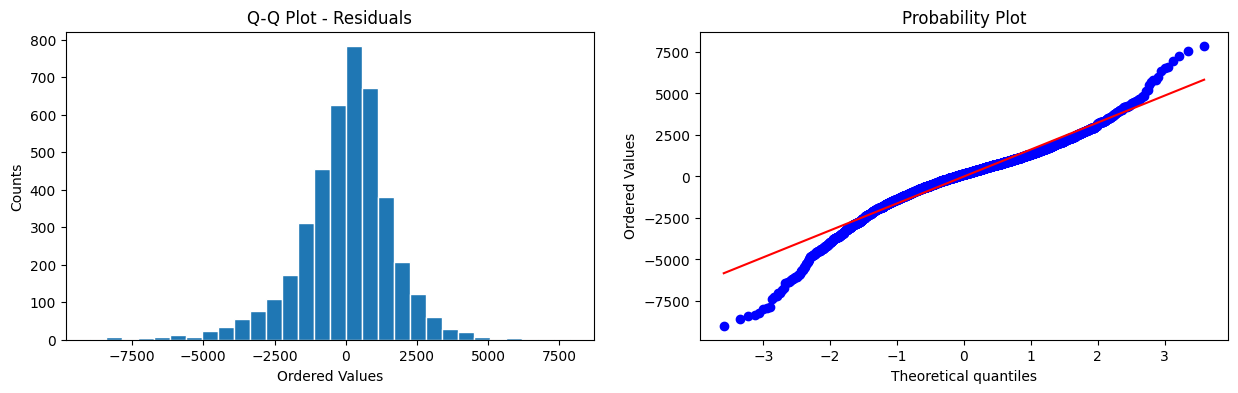

In [59]:
# let's look at the distribution of the residuals

# plotting histogram
fig, axes = plt.subplots(1,2,figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(combined_data.residual, bins=30, edgecolor='w')
plt.title('Distribution - Residuals')
plt.xlabel('Ordered Values')
plt.ylabel('Counts')

stats.probplot(combined_data.residual.dropna().values, dist="norm", plot = axes[1])
plt.title('Q-Q Plot - Residuals')
plt.show()

**<span style='color: DarkRed;'>Apart from the yearly trend that we see in the first plot, we also observe two seasonalities - monthly and weekly. Not conisidering the pandemic years, the yearly trend reflects the growth we have seen previously in our total demand plot. The monthly and weekly seasonality is also captured beautifully and reflect what we have seen in our bar graphs earlier.</span>** 

**<span style='color: DarkRed;'>We also see some heteroscedasticity in the residual component. In the next phase of our project we will look at transformations that may help make our residuals more normally distributed. For now, let's go ahead and build our baseline models.</span>**

<a id="10"></a>
### **Naive Baseline Model**

**<span style='color: DarkRed;'>Our first baseline model is a Naive model. Since we intend to provide short-term forecasts, our first baseline model will assume the predicted value at time `t` to be the actual value of the variable at time `t-1`.</span>**

In [60]:
# Create lagged dataset

shifted_data = combined_data['total_demand'].shift(1)
bike_demand_data = pd.concat([shifted_data,combined_data['total_demand']], axis=1)
bike_demand_data.columns = ['t-1', 't+1']
print(bike_demand_data.head(5))

               t-1     t+1
2012-01-01     NaN  2260.0
2012-01-02  2260.0  1937.0
2012-01-03  1937.0  2219.0
2012-01-04  2219.0  2357.0
2012-01-05  2357.0  3251.0


In [61]:
# creating train and test sets

X = bike_demand_data.values
train_size = int(len(X) * 0.70)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

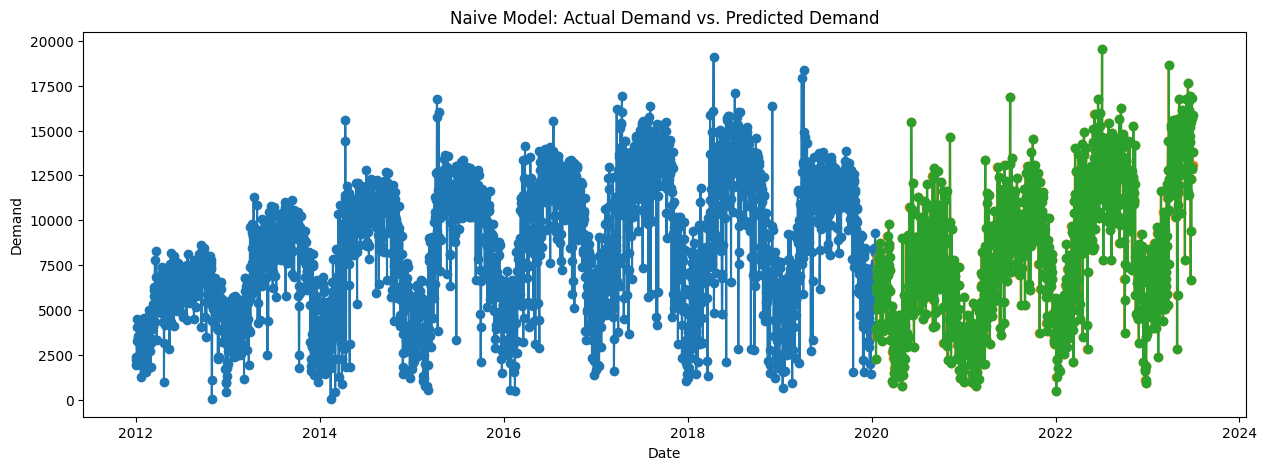

In [62]:
# prediction
predictions = test_X

# plottinig predictions and expected results
plt.figure(figsize=(15,5))
plt.title('Naive Model: Actual Demand vs. Predicted Demand')
plt.plot_date(bike_demand_data.index[1:train_size], train_y, linestyle='solid')
plt.plot_date(bike_demand_data.index[1:], [None for i in train_y] + [x for x in test_y], linestyle='solid')
plt.plot_date(bike_demand_data.index[1:], [None for i in train_y] + [x for x in predictions], linestyle='solid')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.show()

**Let's zoom in to have a better view.**

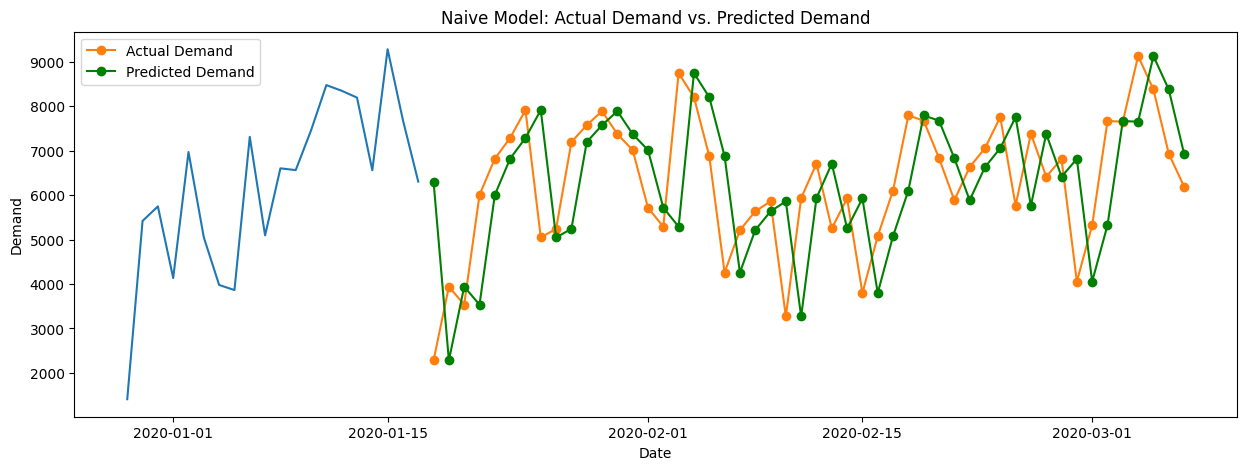

In [63]:
plt.figure(figsize=(15,5))
plt.title('Naive Model: Actual Demand vs. Predicted Demand')
plt.plot(bike_demand_data.index[train_size-20:train_size], train_y[-20:], linestyle='solid')
plt.plot_date(bike_demand_data.index[train_size-20:train_size+50], [None for i in range(20)]+[x for x in test_y][:50], linestyle='solid', label='Actual Demand')
plt.plot_date(bike_demand_data.index[train_size-20:train_size+50], [None for i in range(20)]+[x for x in predictions][:50],linestyle='solid', c='g', label='Predicted Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [64]:
# test score (MSE)

error = mean_squared_error(test_y, predictions)

print(f'Test MSE: {error:.3f}')

Test MSE: 5933717.330


**<span style='color: DarkRed;'>Using our Naive baseline model we got a MSE score of `5,933,717.33` over our entire test set.</span>**

<a id="11"></a>
### **Trend-Season Based Baseline Model**

**<span style='color: DarkRed;'>In this baseline model, we will extract the trend and seasonalities from out training data and use them to forecast demand.</span>**

In [65]:
# train test split using `train_size` from above

train_data = bike_demand_data['t+1'][:train_size]
train_data = train_data.to_frame(name='total_demand')
display(train_data.tail())
test_data = bike_demand_data['t+1'][train_size:]
test_data = test_data.to_frame(name='total_demand')
display(test_data.head())

total_demand
2020-01-13        8193.0
2020-01-14        6559.0
2020-01-15        9281.0
2020-01-16        7685.0
2020-01-17        6303.0

total_demand
2020-01-18        2281.0
2020-01-19        3941.0
2020-01-20        3535.0
2020-01-21        6004.0
2020-01-22        6820.0

In [66]:
# decompose the time series at the month level

train_data_monthly = train_data.resample("M").sum()

decomposition = tsa.seasonal_decompose(train_data_monthly['total_demand'], model='additive')
train_data_monthly["trend"] = decomposition.trend
train_data_monthly["seasonal"] = decomposition.seasonal
train_data_monthly["residual"] = decomposition.resid

In [67]:
# plotting the trend, seasonality and residual at the day level

cols = ["trend", "seasonal", "residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=train_data_monthly.index, y=train_data_monthly[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

In [68]:
# decompose the time series at the day level

decomposition = tsa.seasonal_decompose(train_data, model='additive')
train_data["trend"] = decomposition.trend
train_data["seasonal"] = decomposition.seasonal
train_data["residual"] = decomposition.resid

In [69]:
# plotting the trend, seasonality and residual at the day level

cols = ["trend", "seasonal", "residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=train_data.index, y=train_data[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

**For the purpose of our baseline model we will extract the trend and monthly seasonality from our month-level data decomposition and weekly seasonality from our day-level data decomposition. We will also not be forcasting the trend values, instead, we will assume that the trend curve becomes horizontal at the last trend value.**

In [70]:
# extracting trend and seasonality data

trend = train_data_monthly.trend.dropna()[-1]
ms = [train_data_monthly.seasonal[train_data_monthly.index.month==x][1] for x in range(1,13)]
monthly_seasonal = pd.Series(data=ms, index=range(1,13), name='monthly_seasonal')
ws = [train_data.seasonal[train_data.index.dayofweek==x][1] for x in range(7)]
weekly_seasonal = pd.Series(data=ws, index=range(7), name='weekly_seasonal')

print('Trend Value: ', trend)
print('\nMonthly Seasonal Values: \n')
print(monthly_seasonal)
print('\nWeekly Seasonal Values: \n')
print(weekly_seasonal)

Trend Value:  281579.74999999994

Monthly Seasonal Values: 

1    -119622.741753
2    -114143.979849
3     -47337.694134
4      39483.603485
5      54201.835627
6      72019.722532
7      78234.367622
8      80793.609437
9      60201.174913
10     44218.139199
11    -47377.950087
12   -100670.086992
Name: monthly_seasonal, dtype: float64

Weekly Seasonal Values: 

0   -267.710340
1    115.594467
2    358.337051
3    265.626857
4    304.372169
5    -11.680337
6   -764.539867
Name: weekly_seasonal, dtype: float64


**Great. Now let's write a function to forecast demand.**

In [71]:
def trend_seasonal_forecast(date):
    month = date.month
    day = date.dayofweek
    days_in_month = date.days_in_month
    
    return (trend + monthly_seasonal[month])/days_in_month + weekly_seasonal[day]

In [72]:
# predictions

y_hat = []

for val in test_data.index:
    pred = trend_seasonal_forecast(val)
    y_hat.append(pred)
 

# calculating MSE

error = mean_squared_error(test_data['total_demand'].values, y_hat)

print(f'Test MSE: {error:.3f}')


Test MSE: 11349103.805


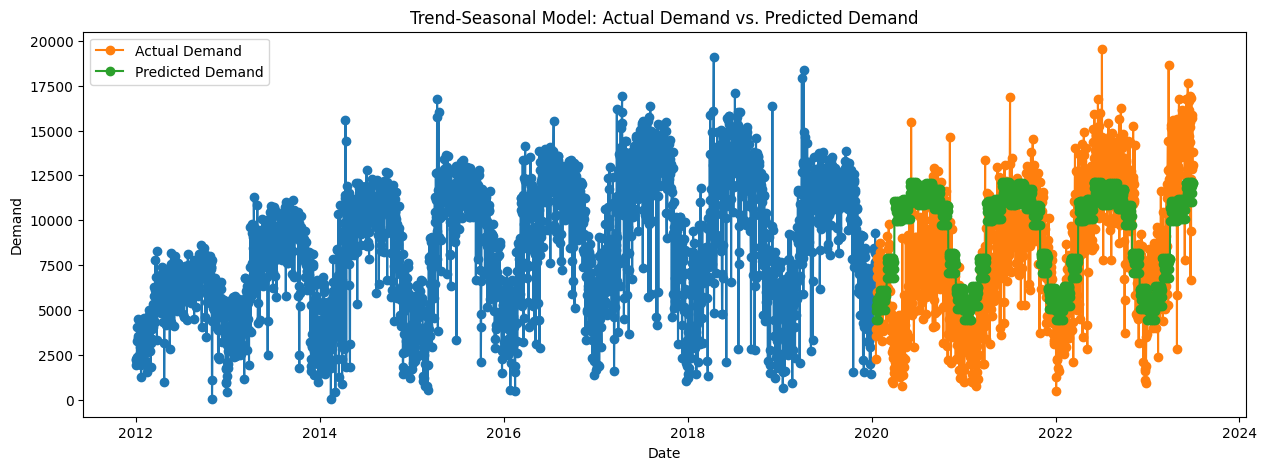

In [73]:
# plottinig predictions and expected results

plt.figure(figsize=(15,5))
plt.title('Trend-Seasonal Model: Actual Demand vs. Predicted Demand')
plt.plot_date(train_data.index, train_data['total_demand'], linestyle='solid')
plt.plot_date(bike_demand_data.index, [None for i in train_data.index] + [x for x in test_data['total_demand']], linestyle='solid', label='Actual Demand')
plt.plot_date(bike_demand_data.index, [None for i in train_data.index] + [x for x in y_hat], linestyle='solid', label='Predicted Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

**<span style='color: DarkRed;'>Even with this crude model we are able to mimic the seasonality in our test data quite well. Let's zoom in to take a look at how this method fared during Covid years and non-Covid years.</span>**

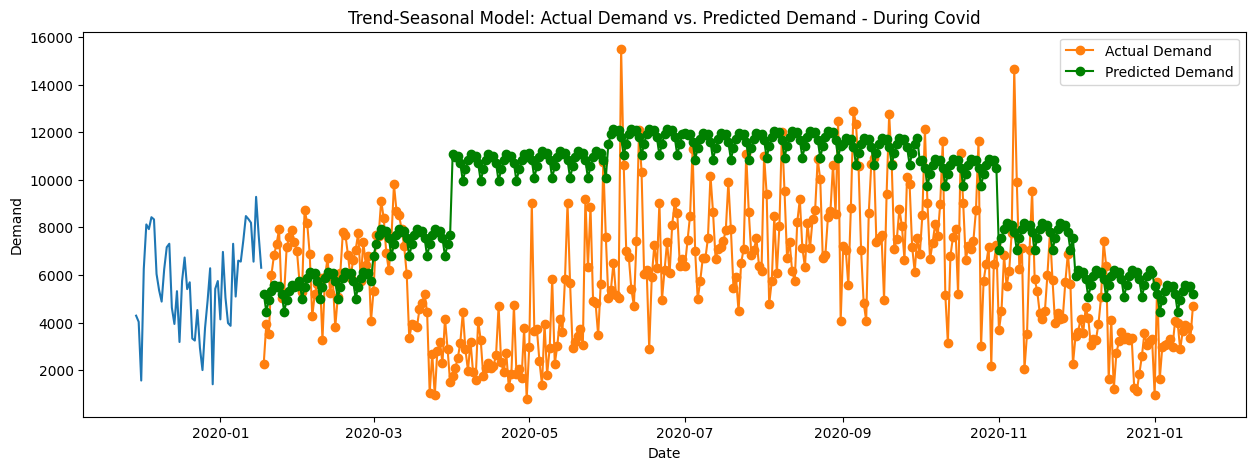

In [74]:
# zooming in and plotting for better understanding

plt.figure(figsize=(15,5))
plt.title('Trend-Seasonal Model: Actual Demand vs. Predicted Demand - During Covid')
plt.plot(bike_demand_data.index[train_size-50:train_size], train_data['total_demand'].values[-50:], linestyle='solid')
plt.plot_date(bike_demand_data.index[train_size-50:train_size+365], [None for i in range(50)]+[x for x in test_data['total_demand'].values][:365], linestyle='solid', label='Actual Demand')
plt.plot_date(bike_demand_data.index[train_size-50:train_size+365], [None for i in range(50)]+[x for x in y_hat][:365],linestyle='solid', c='g', label='Predicted Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

**<span style='color: DarkRed;'>We can see that the model fares quite poorly during the Covid years since the model has not seen such patterns before and this is an anomaly.</span>**

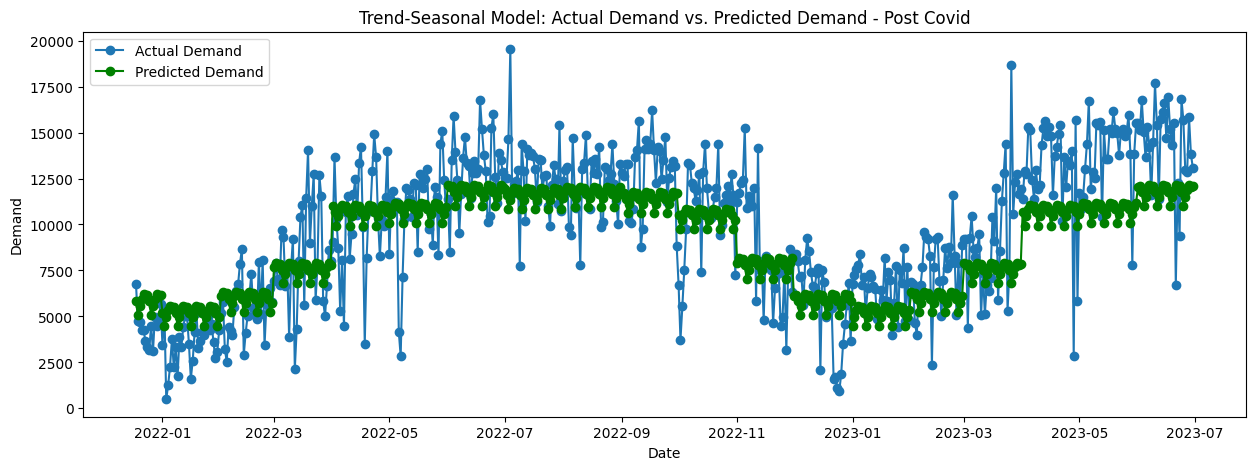

In [75]:
# zooming in post covid years and plotting

plt.figure(figsize=(15,5))
plt.title('Trend-Seasonal Model: Actual Demand vs. Predicted Demand - Post Covid')
plt.plot_date(test_data.index[700:], [x for x in test_data['total_demand'].values][700:], linestyle='solid', label='Actual Demand')
plt.plot_date(test_data.index[700:], [x for x in y_hat][700:],linestyle='solid', c='g', label='Predicted Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()
# plt.savefig('/Users/sonalkiranhansra/Desktop/BrainStation_Sonal/Classes/Capstone/plots/baseline_2_2.png')

In [76]:
# calculating MSE for post covid forecast

error = mean_squared_error(test_data['total_demand'].values[-600:], y_hat[-600:])

print(f'Test MSE: {error:.3f}')

Test MSE: 6847398.178


**<span style='color: DarkRed;'>Post Covid, our model is able to generalise well based on seasonality.</span>**

**<span style='color: DarkRed;'>Based on just this period, our MSE goes down to 6,847,398 from 11,349,103! Though even now the Naive method based model has the lowest MSE at 5,933,717.</span>**

##################################### END OF REPORT #####################################